In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2                         # To read and manipulate images
import matplotlib.pyplot as plt    # Python 2D plotting library
%matplotlib inline  
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
TRAIN_PATH = 'data/CAX_Superhero_Train/'
TEST_PATH = 'data/CAX_Superhero_Test/'
superhero_dic = {'Ant-Man':'ant_man', 'Aquaman':'aqua_man', 'Avengers':'avengers', 'Batman':'bat_man', 
                 'Black Panther':'black_panther', 'Captain America':'captain_america', 'Catwoman':'cat_woman',
                 'Ghost Rider':'ghostrider', 'Hulk':'hulk', 'Iron Man':'iron_man', 'Spiderman':'spider_man', 
                 'Superman':'super_man'}

labelencoder_dic = {0: 'ant_man', 1: 'aqua_man', 2: 'avengers', 3: 'bat_man', 4: 'black_panther', 5: 'captain_america', 
                    6: 'cat_woman', 7: 'ghostrider', 8: 'hulk', 9: 'iron_man', 10: 'spider_man', 11: 'super_man'}

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = 224

train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

torch.random.manual_seed(12345);

In [18]:
#Dataset for PyTorch
class SuperheroesDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)           
        label = self.y[idx]
        out = (img, label)
        return out

#Train model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

# This is a little utility that we'll use to reset the model if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()    
        
def predict(test_loader, model):
    model.eval()       #Sets the module in evaluation mode
    predictions = []
    
    for i, data in enumerate(tqdm(test_loader)):
        inputs, _ = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        predictions.append(preds[0])
        
    return predictions

In [4]:
transform_data = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.CenterCrop(IMG_SIZE),transforms.ToTensor()])

In [5]:
transform_train = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])
transform_test = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

In [6]:
use_gpu = torch.cuda.is_available()

In [7]:
labelencoder = LabelEncoder()

x_train_df = train_df['img_path'].values
y_train_df = train_df['superhero'].values
y_train_df = labelencoder.fit_transform(y_train_df)
x_test_df = test_df['img_path'].values

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=42, 
                                                      shuffle=True, stratify=y_train_df)
x_test = x_test_df
y_test = np.zeros_like(x_test)

In [9]:
batch_size = 16
train_set = SuperheroesDataset(x_train, y_train, transform_train)
train_load = DataLoader(train_set,batch_size=batch_size)
valid_set = SuperheroesDataset(x_valid, y_valid, transform_test)
valid_load = DataLoader(valid_set,batch_size=batch_size)
test_set = SuperheroesDataset(x_test, y_test, transform_test)
test_load = DataLoader(test_set,batch_size=1)

In [10]:
image_datasets = {'train':train_set, 'val':valid_set}
dataloaders    = {'train':train_load, 'val':valid_load}
dataset_sizes  = {'train':len(train_set), 'val':len(valid_set)}

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

torch.random.manual_seed(12345);

Epoch 0/24
----------
train Loss: 2.2099 Acc: 0.2365
val Loss: 1.9640 Acc: 0.3330

Epoch 1/24
----------
train Loss: 1.8402 Acc: 0.4098
val Loss: 2.0976 Acc: 0.4029

Epoch 2/24
----------
train Loss: 1.6441 Acc: 0.4676
val Loss: 2.0159 Acc: 0.4361

Epoch 3/24
----------
train Loss: 1.5317 Acc: 0.5025
val Loss: 1.6157 Acc: 0.5023

Epoch 4/24
----------
train Loss: 1.4325 Acc: 0.5338
val Loss: 1.5622 Acc: 0.5069

Epoch 5/24
----------
train Loss: 1.3307 Acc: 0.5711
val Loss: 1.9953 Acc: 0.4480

Epoch 6/24
----------
train Loss: 1.2610 Acc: 0.5957
val Loss: 1.4824 Acc: 0.5474

Epoch 7/24
----------
train Loss: 1.1429 Acc: 0.6277
val Loss: 1.2273 Acc: 0.5925

Epoch 8/24
----------
train Loss: 1.0668 Acc: 0.6544
val Loss: 1.2129 Acc: 0.6053

Epoch 9/24
----------
train Loss: 1.0306 Acc: 0.6726
val Loss: 1.2012 Acc: 0.6118

Epoch 10/24
----------
train Loss: 0.9995 Acc: 0.6866
val Loss: 1.1943 Acc: 0.6136

Epoch 11/24
----------
train Loss: 0.9696 Acc: 0.6970
val Loss: 1.1856 Acc: 0.6191

Ep

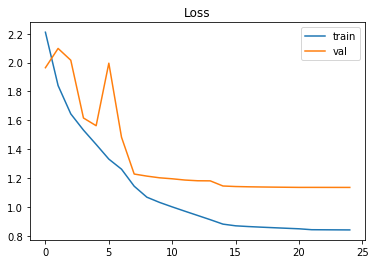

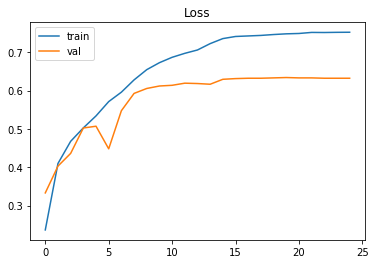

In [11]:
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

In [26]:
torch.save(model_ft, 'model_ft')

In [14]:
predictions = predict(test_load, model_ft)

100%|█████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:19<00:00, 168.78it/s]


In [45]:
def submit_prediction(test_load, model, path):
    predictions = predict(test_load, model)
    d = {'filename': test_df['img_name'], 'Superhero': predictions}
    predict_df = pd.DataFrame(d)
    predict_df = predict_df[['filename', 'Superhero']]
    predict_df['filename'] = predict_df['filename'].map(lambda x: str(x)[:-4])
    predict_df.replace({"Superhero": labelencoder_dic}, inplace=True)

    submission = pd.read_csv('data/Superhero_3375_SampleSubmission.csv')

    # find filename in predict and insert superhero in submission
    for i in tqdm(range(submission.shape[0])):
        filename = submission['filename'].iloc[i]
        submission['Superhero'].iloc[i] = predict_df['Superhero'][predict_df['filename'] == filename].values[0]

    submission.to_csv(path, index=False)

In [25]:
submit_prediction(predictions, 'submit.csv')

100%|████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:02<00:00, 1456.68it/s]


Epoch 0/19
----------
train Loss: 2.0372 Acc: 0.3113
val Loss: 2.4998 Acc: 0.2705

Epoch 1/19
----------
train Loss: 1.8039 Acc: 0.3974
val Loss: 2.3526 Acc: 0.3634

Epoch 2/19
----------
train Loss: 1.6874 Acc: 0.4413
val Loss: 2.3760 Acc: 0.3625

Epoch 3/19
----------
train Loss: 1.5849 Acc: 0.4722
val Loss: 2.4717 Acc: 0.4177

Epoch 4/19
----------
train Loss: 1.5098 Acc: 0.4963
val Loss: 1.9625 Acc: 0.4333

Epoch 5/19
----------
train Loss: 1.4341 Acc: 0.5285
val Loss: 1.5436 Acc: 0.5235

Epoch 6/19
----------
train Loss: 1.3763 Acc: 0.5509
val Loss: 1.4006 Acc: 0.5575

Epoch 7/19
----------
train Loss: 1.2952 Acc: 0.5736
val Loss: 1.6723 Acc: 0.4489

Epoch 8/19
----------
train Loss: 1.2203 Acc: 0.5950
val Loss: 2.5702 Acc: 0.3312

Epoch 9/19
----------
train Loss: 1.1656 Acc: 0.6167
val Loss: 1.7623 Acc: 0.5087

Epoch 10/19
----------
train Loss: 1.0641 Acc: 0.6549
val Loss: 2.3120 Acc: 0.3661

Epoch 11/19
----------
train Loss: 0.9710 Acc: 0.6848
val Loss: 2.7680 Acc: 0.2686

Ep

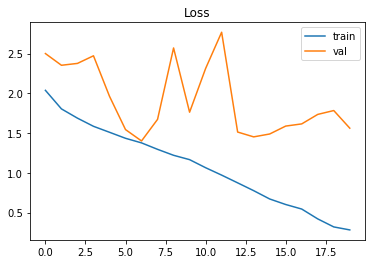

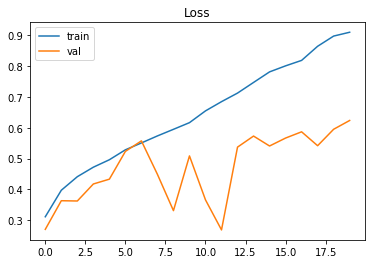

In [28]:
# Adam
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.0442 Acc: 0.3081
val Loss: 2.1676 Acc: 0.3027

Epoch 1/19
----------
train Loss: 1.8004 Acc: 0.3967
val Loss: 1.8581 Acc: 0.3993

Epoch 2/19
----------
train Loss: 1.7073 Acc: 0.4287
val Loss: 1.9718 Acc: 0.4195

Epoch 3/19
----------
train Loss: 1.5913 Acc: 0.4694
val Loss: 1.5988 Acc: 0.4627

Epoch 4/19
----------
train Loss: 1.5173 Acc: 0.4917
val Loss: 1.8735 Acc: 0.4425

Epoch 5/19
----------
train Loss: 1.4530 Acc: 0.5140
val Loss: 1.9911 Acc: 0.4241

Epoch 6/19
----------
train Loss: 1.3899 Acc: 0.5439
val Loss: 1.6400 Acc: 0.4664

Epoch 7/19
----------
train Loss: 1.3053 Acc: 0.5660
val Loss: 1.6520 Acc: 0.4876

Epoch 8/19
----------
train Loss: 1.2296 Acc: 0.5987
val Loss: 2.2866 Acc: 0.4223

Epoch 9/19
----------
train Loss: 1.1604 Acc: 0.6123
val Loss: 1.6606 Acc: 0.5069

Epoch 10/19
----------
train Loss: 1.0976 Acc: 0.6371
val Loss: 2.5773 Acc: 0.4333

Epoch 11/19
----------
train Loss: 1.0242 Acc: 0.6638
val Loss: 2.6020 Acc: 0.4425

Ep

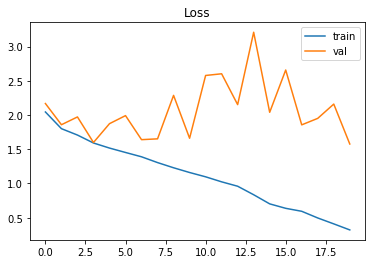

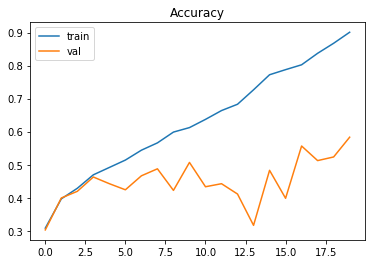

In [35]:
# gamma=1
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.2090 Acc: 0.2342
val Loss: 2.0164 Acc: 0.3284

Epoch 1/19
----------
train Loss: 1.8366 Acc: 0.4077
val Loss: 1.9573 Acc: 0.3928

Epoch 2/19
----------
train Loss: 1.6406 Acc: 0.4639
val Loss: 1.6110 Acc: 0.4940

Epoch 3/19
----------
train Loss: 1.5204 Acc: 0.5062
val Loss: 1.5635 Acc: 0.4922

Epoch 4/19
----------
train Loss: 1.4184 Acc: 0.5396
val Loss: 1.4211 Acc: 0.5437

Epoch 5/19
----------
train Loss: 1.3309 Acc: 0.5640
val Loss: 1.4706 Acc: 0.5198

Epoch 6/19
----------
train Loss: 1.2387 Acc: 0.5966
val Loss: 1.4675 Acc: 0.5087

Epoch 7/19
----------
train Loss: 1.1614 Acc: 0.6256
val Loss: 1.4399 Acc: 0.5299

Epoch 8/19
----------
train Loss: 1.0716 Acc: 0.6652
val Loss: 1.3960 Acc: 0.5428

Epoch 9/19
----------
train Loss: 0.9728 Acc: 0.6926
val Loss: 1.6832 Acc: 0.5235

Epoch 10/19
----------
train Loss: 0.8693 Acc: 0.7335
val Loss: 1.7179 Acc: 0.4986

Epoch 11/19
----------
train Loss: 0.7846 Acc: 0.7591
val Loss: 3.6755 Acc: 0.2466

Ep

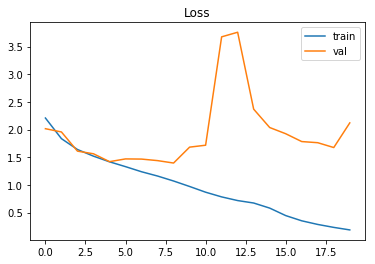

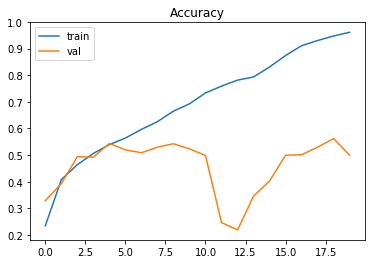

In [37]:
# without gamma
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_3 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.4132 Acc: 0.1392
val Loss: 2.3297 Acc: 0.1831

Epoch 1/19
----------
train Loss: 2.2896 Acc: 0.2108
val Loss: 2.2290 Acc: 0.2668

Epoch 2/19
----------
train Loss: 2.2126 Acc: 0.2763
val Loss: 2.1508 Acc: 0.2787

Epoch 3/19
----------
train Loss: 2.1433 Acc: 0.2934
val Loss: 2.0844 Acc: 0.2907

Epoch 4/19
----------
train Loss: 2.0778 Acc: 0.3079
val Loss: 2.0230 Acc: 0.3109

Epoch 5/19
----------
train Loss: 2.0155 Acc: 0.3279
val Loss: 1.9679 Acc: 0.3477

Epoch 6/19
----------
train Loss: 1.9563 Acc: 0.3640
val Loss: 1.9109 Acc: 0.3809

Epoch 7/19
----------
train Loss: 1.9171 Acc: 0.3847
val Loss: 1.9009 Acc: 0.3790

Epoch 8/19
----------
train Loss: 1.9111 Acc: 0.3879
val Loss: 1.8953 Acc: 0.3845

Epoch 9/19
----------
train Loss: 1.9056 Acc: 0.3898
val Loss: 1.8901 Acc: 0.3864

Epoch 10/19
----------
train Loss: 1.9003 Acc: 0.3914
val Loss: 1.8849 Acc: 0.3873

Epoch 11/19
----------
train Loss: 1.8951 Acc: 0.3948
val Loss: 1.8800 Acc: 0.3882

Ep

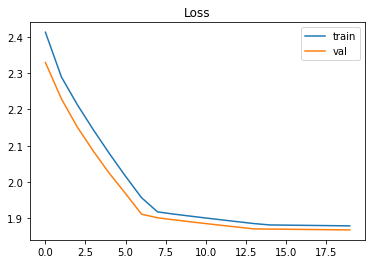

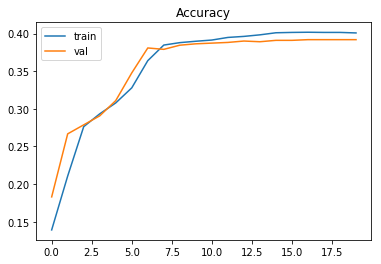

In [38]:
# without momentum
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_4 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.2085 Acc: 0.2377
val Loss: 1.9811 Acc: 0.3275

Epoch 1/19
----------
train Loss: 1.8359 Acc: 0.4075
val Loss: 1.8518 Acc: 0.4186

Epoch 2/19
----------
train Loss: 1.6413 Acc: 0.4669
val Loss: 1.6021 Acc: 0.4959

Epoch 3/19
----------
train Loss: 1.5229 Acc: 0.4975
val Loss: 1.4801 Acc: 0.5281

Epoch 4/19
----------
train Loss: 1.4220 Acc: 0.5345
val Loss: 1.4944 Acc: 0.5299

Epoch 5/19
----------
train Loss: 1.3382 Acc: 0.5626
val Loss: 1.4428 Acc: 0.5317

Epoch 6/19
----------
train Loss: 1.2566 Acc: 0.5932
val Loss: 2.2155 Acc: 0.4499

Epoch 7/19
----------
train Loss: 1.1524 Acc: 0.6233
val Loss: 1.2248 Acc: 0.6090

Epoch 8/19
----------
train Loss: 1.0705 Acc: 0.6549
val Loss: 1.2155 Acc: 0.6072

Epoch 9/19
----------
train Loss: 1.0328 Acc: 0.6682
val Loss: 1.2059 Acc: 0.6063

Epoch 10/19
----------
train Loss: 0.9997 Acc: 0.6832
val Loss: 1.2037 Acc: 0.6090

Epoch 11/19
----------
train Loss: 0.9687 Acc: 0.6977
val Loss: 1.1957 Acc: 0.6118

Ep

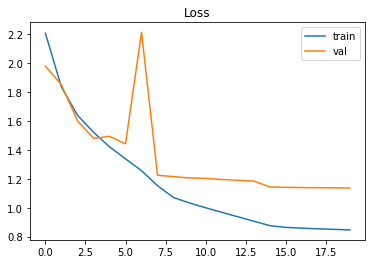

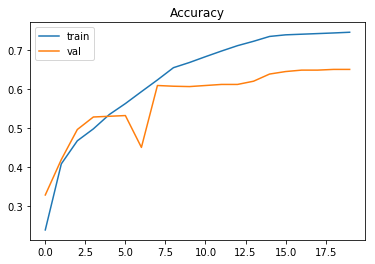

In [39]:
# step_size=14
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_4 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.2103 Acc: 0.2398
val Loss: 1.9780 Acc: 0.3404

Epoch 1/19
----------
train Loss: 1.8417 Acc: 0.3999
val Loss: 1.8524 Acc: 0.4149

Epoch 2/19
----------
train Loss: 1.6514 Acc: 0.4678
val Loss: 1.8250 Acc: 0.4554

Epoch 3/19
----------
train Loss: 1.5327 Acc: 0.4977
val Loss: 1.5375 Acc: 0.5189

Epoch 4/19
----------
train Loss: 1.4287 Acc: 0.5384
val Loss: 1.4297 Acc: 0.5419

Epoch 5/19
----------
train Loss: 1.3460 Acc: 0.5557
val Loss: 1.8477 Acc: 0.4526

Epoch 6/19
----------
train Loss: 1.2627 Acc: 0.5918
val Loss: 1.4318 Acc: 0.5299

Epoch 7/19
----------
train Loss: 1.1213 Acc: 0.6362
val Loss: 1.2194 Acc: 0.6053

Epoch 8/19
----------
train Loss: 1.0555 Acc: 0.6595
val Loss: 1.2029 Acc: 0.6109

Epoch 9/19
----------
train Loss: 1.0217 Acc: 0.6760
val Loss: 1.1938 Acc: 0.6145

Epoch 10/19
----------
train Loss: 0.9912 Acc: 0.6859
val Loss: 1.1841 Acc: 0.6164

Epoch 11/19
----------
train Loss: 0.9616 Acc: 0.6977
val Loss: 1.1730 Acc: 0.6191

Ep

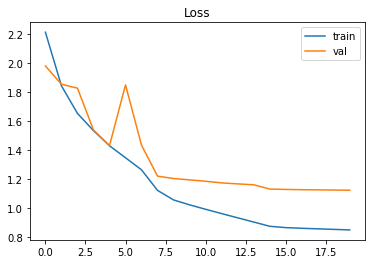

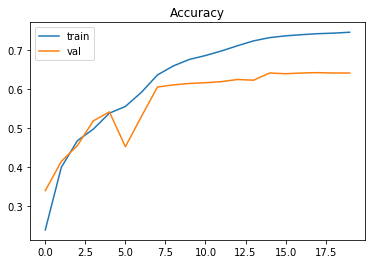

In [40]:
# lr=0.01
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_4 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.3443 Acc: 0.2138
val Loss: 2.1634 Acc: 0.2778

Epoch 1/19
----------
train Loss: 2.0620 Acc: 0.3148
val Loss: 2.7219 Acc: 0.2438

Epoch 2/19
----------
train Loss: 1.9437 Acc: 0.3382
val Loss: 2.0821 Acc: 0.3257

Epoch 3/19
----------
train Loss: 1.8785 Acc: 0.3629
val Loss: 2.3598 Acc: 0.3063

Epoch 4/19
----------
train Loss: 1.7986 Acc: 0.3868
val Loss: 2.2933 Acc: 0.2751

Epoch 5/19
----------
train Loss: 1.7156 Acc: 0.4144
val Loss: 1.8514 Acc: 0.3588

Epoch 6/19
----------
train Loss: 1.6561 Acc: 0.4411
val Loss: 2.1341 Acc: 0.3266

Epoch 7/19
----------
train Loss: 1.6060 Acc: 0.4565
val Loss: 1.6067 Acc: 0.4765

Epoch 8/19
----------
train Loss: 1.5378 Acc: 0.4871
val Loss: 1.8506 Acc: 0.4388

Epoch 9/19
----------
train Loss: 1.4582 Acc: 0.5175
val Loss: 1.9144 Acc: 0.4351

Epoch 10/19
----------
train Loss: 1.3711 Acc: 0.5465
val Loss: 1.7146 Acc: 0.4563

Epoch 11/19
----------
train Loss: 1.2955 Acc: 0.5725
val Loss: 1.9500 Acc: 0.4554

Ep

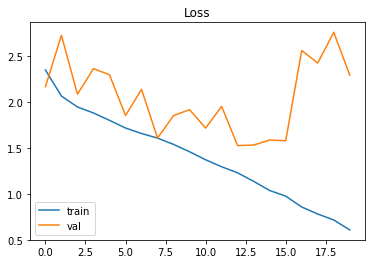

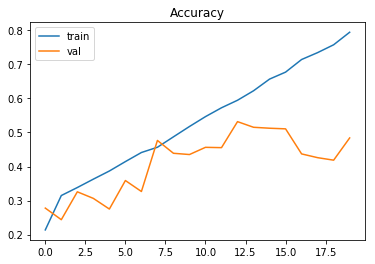

In [41]:
# Adam lr = 0.01
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.0334 Acc: 0.3118
val Loss: 1.9733 Acc: 0.3551

Epoch 1/19
----------
train Loss: 1.7994 Acc: 0.4040
val Loss: 2.0714 Acc: 0.3413

Epoch 2/19
----------
train Loss: 1.6833 Acc: 0.4367
val Loss: 2.0939 Acc: 0.3873

Epoch 3/19
----------
train Loss: 1.5802 Acc: 0.4708
val Loss: 2.2013 Acc: 0.3993

Epoch 4/19
----------
train Loss: 1.5173 Acc: 0.4883
val Loss: 2.1315 Acc: 0.3671

Epoch 5/19
----------
train Loss: 1.4496 Acc: 0.5179
val Loss: 3.1988 Acc: 0.2392

Epoch 6/19
----------
train Loss: 1.3601 Acc: 0.5538
val Loss: 1.6796 Acc: 0.4609

Epoch 7/19
----------
train Loss: 1.2741 Acc: 0.5773
val Loss: 1.5180 Acc: 0.5345

Epoch 8/19
----------
train Loss: 1.2136 Acc: 0.5966
val Loss: 2.2606 Acc: 0.4627

Epoch 9/19
----------
train Loss: 1.1501 Acc: 0.6203
val Loss: 1.8880 Acc: 0.4857

Epoch 10/19
----------
train Loss: 1.0500 Acc: 0.6608
val Loss: 2.0183 Acc: 0.4903

Epoch 11/19
----------
train Loss: 0.9456 Acc: 0.6894
val Loss: 2.5012 Acc: 0.4407

Ep

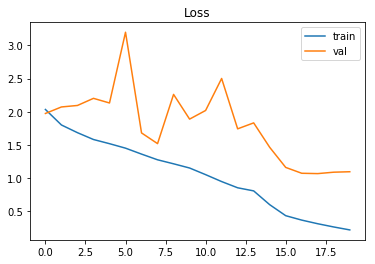

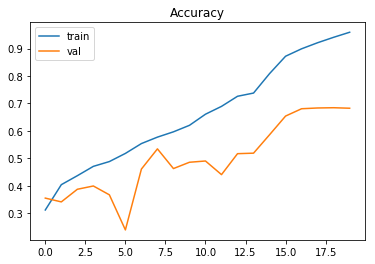

In [42]:
# Adam step_size=14
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=14, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/99
----------
train Loss: 2.0350 Acc: 0.3136
val Loss: 2.4308 Acc: 0.2567

Epoch 1/99
----------
train Loss: 1.7995 Acc: 0.4022
val Loss: 1.9471 Acc: 0.3965

Epoch 2/99
----------
train Loss: 1.6792 Acc: 0.4422
val Loss: 2.1064 Acc: 0.3818

Epoch 3/99
----------
train Loss: 1.5950 Acc: 0.4643
val Loss: 2.1571 Acc: 0.4241

Epoch 4/99
----------
train Loss: 1.5325 Acc: 0.4864
val Loss: 2.3814 Acc: 0.4066

Epoch 5/99
----------
train Loss: 1.4307 Acc: 0.5276
val Loss: 2.0124 Acc: 0.4637

Epoch 6/99
----------
train Loss: 1.3511 Acc: 0.5536
val Loss: 2.0316 Acc: 0.4591

Epoch 7/99
----------
train Loss: 1.2802 Acc: 0.5789
val Loss: 1.4741 Acc: 0.5428

Epoch 8/99
----------
train Loss: 1.2057 Acc: 0.6003
val Loss: 1.4376 Acc: 0.5281

Epoch 9/99
----------
train Loss: 1.1380 Acc: 0.6229
val Loss: 1.5030 Acc: 0.5557

Epoch 10/99
----------
train Loss: 1.0796 Acc: 0.6436
val Loss: 1.6931 Acc: 0.5143

Epoch 11/99
----------
train Loss: 0.9603 Acc: 0.6894
val Loss: 1.8186 Acc: 0.4821

Ep

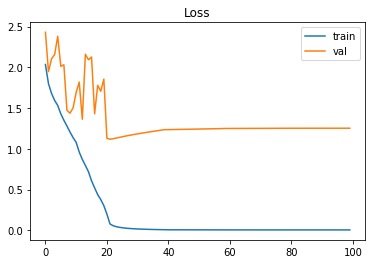

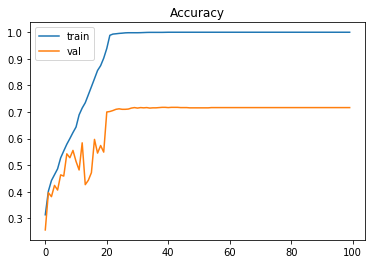

In [43]:
# Adam step_size=20, num_epochs=100
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

In [44]:
torch.save(model_ft_2, 'model_ft_2')

In [46]:
submit_prediction(test_load, model_ft_2, 'submit.csv')

100%|████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:02<00:00, 1367.44it/s]


Epoch 0/29
----------
train Loss: 2.0371 Acc: 0.3058
val Loss: 3.7888 Acc: 0.1886

Epoch 1/29
----------
train Loss: 1.8094 Acc: 0.3843
val Loss: 2.3200 Acc: 0.3441

Epoch 2/29
----------
train Loss: 1.6788 Acc: 0.4383
val Loss: 1.8089 Acc: 0.4278

Epoch 3/29
----------
train Loss: 1.5937 Acc: 0.4733
val Loss: 2.2215 Acc: 0.3137

Epoch 4/29
----------
train Loss: 1.5220 Acc: 0.4896
val Loss: 1.8296 Acc: 0.3993

Epoch 5/29
----------
train Loss: 1.4497 Acc: 0.5138
val Loss: 2.1625 Acc: 0.4232

Epoch 6/29
----------
train Loss: 1.3558 Acc: 0.5479
val Loss: 2.1507 Acc: 0.4241

Epoch 7/29
----------
train Loss: 1.2841 Acc: 0.5727
val Loss: 1.6954 Acc: 0.5014

Epoch 8/29
----------
train Loss: 1.2048 Acc: 0.5971
val Loss: 2.1054 Acc: 0.4167

Epoch 9/29
----------
train Loss: 1.1213 Acc: 0.6289
val Loss: 1.9220 Acc: 0.4269

Epoch 10/29
----------
train Loss: 1.0328 Acc: 0.6636
val Loss: 1.6611 Acc: 0.5179

Epoch 11/29
----------
train Loss: 0.9307 Acc: 0.6995
val Loss: 2.2652 Acc: 0.3983

Ep

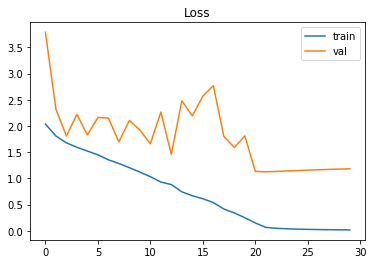

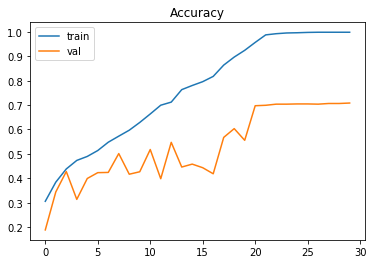

In [11]:
# Adam step_size=20, num_epochs=30
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [12]:
torch.save(model_ft_2, 'model_ft_3')

Epoch 0/29
----------
train Loss: 2.0367 Acc: 0.3092
val Loss: 2.1042 Acc: 0.2714

Epoch 1/29
----------
train Loss: 1.7998 Acc: 0.3879
val Loss: 3.3684 Acc: 0.2263

Epoch 2/29
----------
train Loss: 1.6823 Acc: 0.4372
val Loss: 1.7284 Acc: 0.4241

Epoch 3/29
----------
train Loss: 1.6103 Acc: 0.4584
val Loss: 1.8471 Acc: 0.4241

Epoch 4/29
----------
train Loss: 1.5424 Acc: 0.4834
val Loss: 1.7462 Acc: 0.4453

Epoch 5/29
----------
train Loss: 1.4590 Acc: 0.5113
val Loss: 1.5837 Acc: 0.4876

Epoch 6/29
----------
train Loss: 1.3836 Acc: 0.5359
val Loss: 2.6269 Acc: 0.3017

Epoch 7/29
----------
train Loss: 1.3362 Acc: 0.5575
val Loss: 2.3232 Acc: 0.4167

Epoch 8/29
----------
train Loss: 1.2646 Acc: 0.5766
val Loss: 2.1572 Acc: 0.4545

Epoch 9/29
----------
train Loss: 1.1912 Acc: 0.6035
val Loss: 2.1523 Acc: 0.4425

Epoch 10/29
----------
train Loss: 1.0962 Acc: 0.6417
val Loss: 1.9309 Acc: 0.4480

Epoch 11/29
----------
train Loss: 1.0116 Acc: 0.6654
val Loss: 2.0642 Acc: 0.4710

Ep

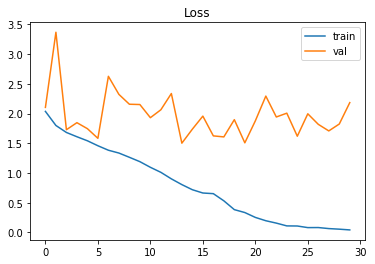

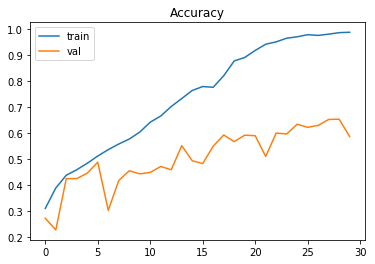

In [12]:
# Adam step_size=40, num_epochs=30
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=40, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_3 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.0392 Acc: 0.3109
val Loss: 2.4229 Acc: 0.2907

Epoch 1/29
----------
train Loss: 1.8256 Acc: 0.3912
val Loss: 1.9222 Acc: 0.4103

Epoch 2/29
----------
train Loss: 1.6996 Acc: 0.4277
val Loss: 1.6577 Acc: 0.4480

Epoch 3/29
----------
train Loss: 1.6149 Acc: 0.4602
val Loss: 2.4302 Acc: 0.3321

Epoch 4/29
----------
train Loss: 1.5397 Acc: 0.4910
val Loss: 2.0810 Acc: 0.3873

Epoch 5/29
----------
train Loss: 1.4810 Acc: 0.5113
val Loss: 1.7300 Acc: 0.4462

Epoch 6/29
----------
train Loss: 1.4146 Acc: 0.5324
val Loss: 1.8111 Acc: 0.4333

Epoch 7/29
----------
train Loss: 1.3527 Acc: 0.5571
val Loss: 2.1760 Acc: 0.3661

Epoch 8/29
----------
train Loss: 1.2905 Acc: 0.5748
val Loss: 1.6270 Acc: 0.4922

Epoch 9/29
----------
train Loss: 1.2104 Acc: 0.5992
val Loss: 1.4229 Acc: 0.5575

Epoch 10/29
----------
train Loss: 1.1399 Acc: 0.6254
val Loss: 1.4344 Acc: 0.5308

Epoch 11/29
----------
train Loss: 1.0634 Acc: 0.6477
val Loss: 3.8756 Acc: 0.3229

Ep

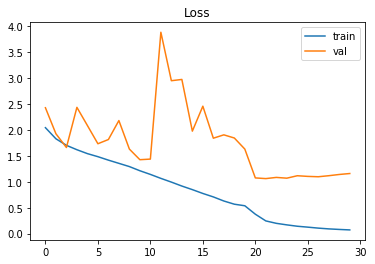

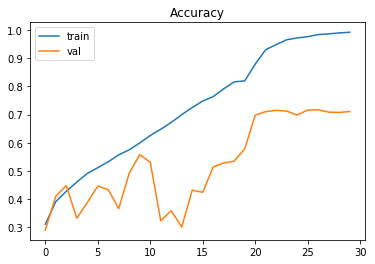

In [19]:
# Adam step_size=20, num_epochs=30, transforms.RandomHorizontalFlip(), pretrained=False
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_4 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.0331 Acc: 0.3182
val Loss: 2.0204 Acc: 0.3726

Epoch 1/29
----------
train Loss: 1.7856 Acc: 0.4006
val Loss: 2.0110 Acc: 0.3855

Epoch 2/29
----------
train Loss: 1.6914 Acc: 0.4340
val Loss: 1.9423 Acc: 0.3726

Epoch 3/29
----------
train Loss: 1.6220 Acc: 0.4468
val Loss: 1.7265 Acc: 0.4186

Epoch 4/29
----------
train Loss: 1.5627 Acc: 0.4772
val Loss: 1.8826 Acc: 0.4278

Epoch 5/29
----------
train Loss: 1.4999 Acc: 0.4972
val Loss: 1.9016 Acc: 0.4020

Epoch 6/29
----------
train Loss: 1.4172 Acc: 0.5274
val Loss: 2.5488 Acc: 0.3533

Epoch 7/29
----------
train Loss: 1.3441 Acc: 0.5476
val Loss: 2.1279 Acc: 0.4232

Epoch 8/29
----------
train Loss: 1.2706 Acc: 0.5732
val Loss: 1.5561 Acc: 0.5391

Epoch 9/29
----------
train Loss: 1.2156 Acc: 0.5953
val Loss: 1.5949 Acc: 0.5041

Epoch 10/29
----------
train Loss: 1.1444 Acc: 0.6148
val Loss: 1.5620 Acc: 0.5446

Epoch 11/29
----------
train Loss: 1.0840 Acc: 0.6436
val Loss: 1.5840 Acc: 0.5097

Ep

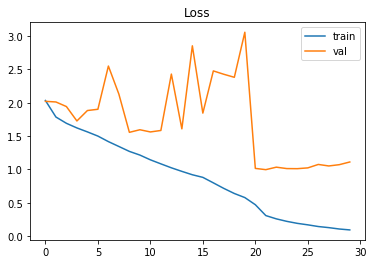

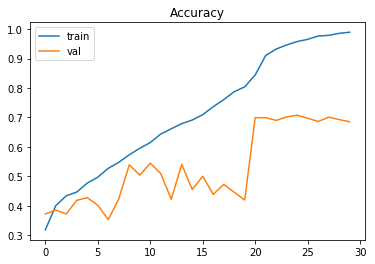

In [16]:
# Adam step_size=20, num_epochs=30, transforms.RandomHorizontalFlip(), pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_4 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.0616 Acc: 0.2952
val Loss: 2.0858 Acc: 0.2843

Epoch 1/29
----------
train Loss: 1.8220 Acc: 0.3919
val Loss: 2.0740 Acc: 0.3312

Epoch 2/29
----------
train Loss: 1.7054 Acc: 0.4280
val Loss: 1.5928 Acc: 0.4940

Epoch 3/29
----------
train Loss: 1.6320 Acc: 0.4547
val Loss: 1.6863 Acc: 0.4480

Epoch 4/29
----------
train Loss: 1.5368 Acc: 0.4841
val Loss: 1.5932 Acc: 0.4756

Epoch 5/29
----------
train Loss: 1.4736 Acc: 0.5110
val Loss: 1.6558 Acc: 0.4600

Epoch 6/29
----------
train Loss: 1.3966 Acc: 0.5364
val Loss: 1.4260 Acc: 0.5179

Epoch 7/29
----------
train Loss: 1.3445 Acc: 0.5495
val Loss: 1.4820 Acc: 0.5189

Epoch 8/29
----------
train Loss: 1.2747 Acc: 0.5778
val Loss: 1.3518 Acc: 0.5603

Epoch 9/29
----------
train Loss: 1.1975 Acc: 0.5983
val Loss: 1.6747 Acc: 0.4894

Epoch 10/29
----------
train Loss: 1.1419 Acc: 0.6213
val Loss: 1.2578 Acc: 0.5814

Epoch 11/29
----------
train Loss: 1.0672 Acc: 0.6535
val Loss: 1.7277 Acc: 0.4701

Ep

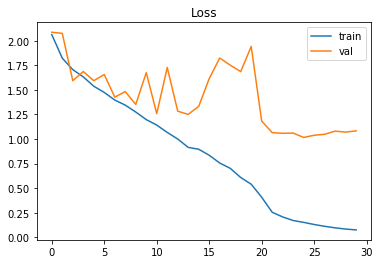

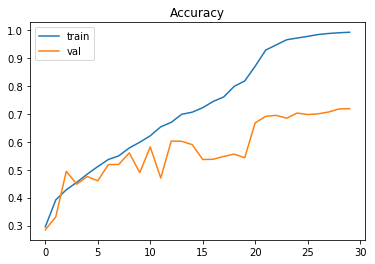

In [34]:
# Adam step_size=20, num_epochs=30, transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_5 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.1836 Acc: 0.2572
val Loss: 2.6845 Acc: 0.2180

Epoch 1/29
----------
train Loss: 1.9946 Acc: 0.3118
val Loss: 1.8550 Acc: 0.3321

Epoch 2/29
----------
train Loss: 1.8926 Acc: 0.3504
val Loss: 3.6252 Acc: 0.1656

Epoch 3/29
----------
train Loss: 1.8218 Acc: 0.3866
val Loss: 2.7117 Acc: 0.2539

Epoch 4/29
----------
train Loss: 1.7398 Acc: 0.4204
val Loss: 2.7153 Acc: 0.2852

Epoch 5/29
----------
train Loss: 1.6775 Acc: 0.4351
val Loss: 2.1366 Acc: 0.3174

Epoch 6/29
----------
train Loss: 1.6488 Acc: 0.4445
val Loss: 2.1603 Acc: 0.3063

Epoch 7/29
----------
train Loss: 1.6043 Acc: 0.4646
val Loss: 1.6226 Acc: 0.4729

Epoch 8/29
----------
train Loss: 1.5291 Acc: 0.4834
val Loss: 2.2222 Acc: 0.3349

Epoch 9/29
----------
train Loss: 1.4872 Acc: 0.5002
val Loss: 2.0410 Acc: 0.3625

Epoch 10/29
----------
train Loss: 1.4275 Acc: 0.5179
val Loss: 1.5686 Acc: 0.5143

Epoch 11/29
----------
train Loss: 1.3849 Acc: 0.5382
val Loss: 2.2965 Acc: 0.3836

Ep

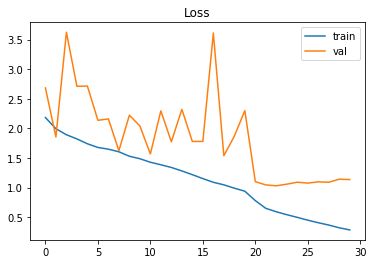

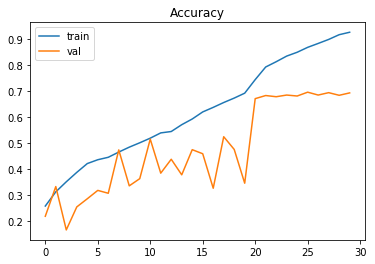

In [23]:
# batch_size=256 not True, Adam, step_size=20, num_epochs=30, transforms.RandomHorizontalFlip(), pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_5 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.0493 Acc: 0.3042
val Loss: 2.6574 Acc: 0.2107

Epoch 1/29
----------
train Loss: 1.7278 Acc: 0.4245
val Loss: 1.7575 Acc: 0.4526

Epoch 2/29
----------
train Loss: 1.6245 Acc: 0.4613
val Loss: 2.0294 Acc: 0.3827

Epoch 3/29
----------
train Loss: 1.5518 Acc: 0.4830
val Loss: 1.9376 Acc: 0.3827

Epoch 4/29
----------
train Loss: 1.4920 Acc: 0.5053
val Loss: 2.8701 Acc: 0.3422

Epoch 5/29
----------
train Loss: 1.4096 Acc: 0.5315
val Loss: 2.1759 Acc: 0.4609

Epoch 6/29
----------
train Loss: 1.3371 Acc: 0.5578
val Loss: 3.3519 Acc: 0.3836

Epoch 7/29
----------
train Loss: 1.2680 Acc: 0.5828
val Loss: 1.8562 Acc: 0.4618

Epoch 8/29
----------
train Loss: 1.2045 Acc: 0.6001
val Loss: 1.7738 Acc: 0.4738

Epoch 9/29
----------
train Loss: 1.1302 Acc: 0.6305
val Loss: 2.0236 Acc: 0.4765

Epoch 10/29
----------
train Loss: 1.0880 Acc: 0.6381
val Loss: 1.8105 Acc: 0.4968

Epoch 11/29
----------
train Loss: 1.0305 Acc: 0.6682
val Loss: 2.3456 Acc: 0.4177

Ep

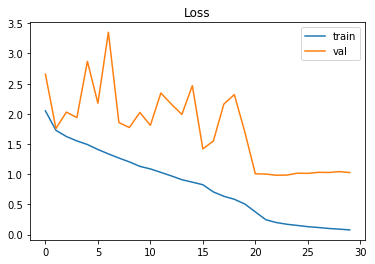

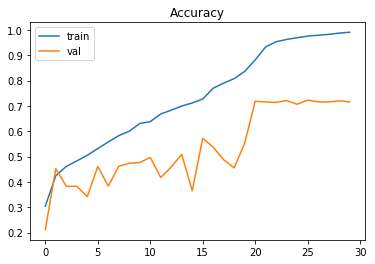

In [15]:
# batch_size=256, Adam, step_size=20, num_epochs=30, transforms.RandomHorizontalFlip(), pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft_5 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [20]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

Epoch 0/29
----------
train Loss: 2.1873 Acc: 0.2563
val Loss: 1.9955 Acc: 0.3293

Epoch 1/29
----------
train Loss: 1.9665 Acc: 0.3403
val Loss: 2.1641 Acc: 0.2981

Epoch 2/29
----------
train Loss: 1.8487 Acc: 0.3760
val Loss: 2.3590 Acc: 0.2392

Epoch 3/29
----------
train Loss: 1.7841 Acc: 0.4077
val Loss: 1.8478 Acc: 0.4002

Epoch 4/29
----------
train Loss: 1.6865 Acc: 0.4347
val Loss: 1.8491 Acc: 0.3947

Epoch 5/29
----------
train Loss: 1.6221 Acc: 0.4551
val Loss: 1.6360 Acc: 0.4591

Epoch 6/29
----------
train Loss: 1.5712 Acc: 0.4781
val Loss: 1.7721 Acc: 0.4048

Epoch 7/29
----------
train Loss: 1.5415 Acc: 0.4765
val Loss: 1.7096 Acc: 0.4462

Epoch 8/29
----------
train Loss: 1.4845 Acc: 0.5133
val Loss: 2.0053 Acc: 0.4305

Epoch 9/29
----------
train Loss: 1.4247 Acc: 0.5269
val Loss: 1.9160 Acc: 0.4167

Epoch 10/29
----------
train Loss: 1.3761 Acc: 0.5444
val Loss: 1.4734 Acc: 0.5465

Epoch 11/29
----------
train Loss: 1.3079 Acc: 0.5640
val Loss: 1.8202 Acc: 0.4315

Ep

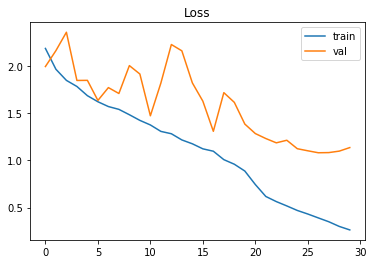

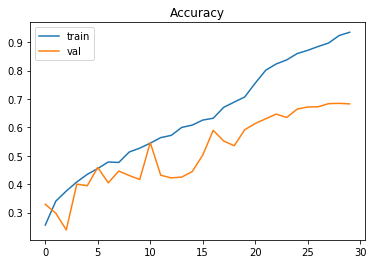

In [13]:
# resnet34, Adam, step_size=20, num_epochs=30, pretrained=False
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs34_1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.2558 Acc: 0.2349
val Loss: 2.4439 Acc: 0.2695

Epoch 1/29
----------
train Loss: 1.9990 Acc: 0.3159
val Loss: 2.4556 Acc: 0.2962

Epoch 2/29
----------
train Loss: 1.8652 Acc: 0.3806
val Loss: 2.0595 Acc: 0.3468

Epoch 3/29
----------
train Loss: 1.7928 Acc: 0.4015
val Loss: 1.8677 Acc: 0.3809

Epoch 4/29
----------
train Loss: 1.7124 Acc: 0.4307
val Loss: 1.8389 Acc: 0.4186

Epoch 5/29
----------
train Loss: 1.6266 Acc: 0.4579
val Loss: 3.3152 Acc: 0.2760

Epoch 6/29
----------
train Loss: 1.5728 Acc: 0.4818
val Loss: 2.1816 Acc: 0.3395

Epoch 7/29
----------
train Loss: 1.5341 Acc: 0.4915
val Loss: 1.6038 Acc: 0.4765

Epoch 8/29
----------
train Loss: 1.4613 Acc: 0.5168
val Loss: 1.7158 Acc: 0.4591

Epoch 9/29
----------
train Loss: 1.4004 Acc: 0.5327
val Loss: 1.7631 Acc: 0.4738

Epoch 10/29
----------
train Loss: 1.3768 Acc: 0.5364
val Loss: 2.1309 Acc: 0.4020

Epoch 11/29
----------
train Loss: 1.3400 Acc: 0.5545
val Loss: 2.2100 Acc: 0.4315

Ep

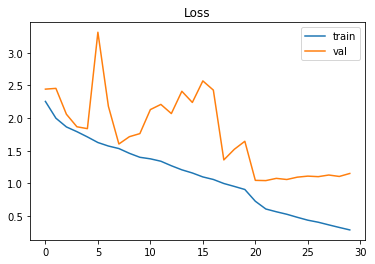

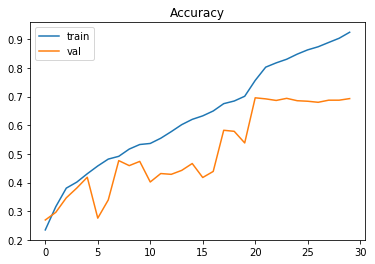

In [18]:
# resnet34, Adam, step_size=20, num_epochs=30, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs34_1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.1788 Acc: 0.2780
val Loss: 2.1609 Acc: 0.3229

Epoch 1/29
----------
train Loss: 1.9145 Acc: 0.3548
val Loss: 2.1945 Acc: 0.3542

Epoch 2/29
----------
train Loss: 1.7973 Acc: 0.3971
val Loss: 2.0694 Acc: 0.3671

Epoch 3/29
----------
train Loss: 1.7024 Acc: 0.4351
val Loss: 1.9288 Acc: 0.4011

Epoch 4/29
----------
train Loss: 1.6424 Acc: 0.4567
val Loss: 2.4761 Acc: 0.2824

Epoch 5/29
----------
train Loss: 1.6057 Acc: 0.4620
val Loss: 1.6311 Acc: 0.4618

Epoch 6/29
----------
train Loss: 1.5398 Acc: 0.4857
val Loss: 1.5710 Acc: 0.4977

Epoch 7/29
----------
train Loss: 1.5071 Acc: 0.4908
val Loss: 1.7662 Acc: 0.4443

Epoch 8/29
----------
train Loss: 1.4618 Acc: 0.5147
val Loss: 1.5070 Acc: 0.5271

Epoch 9/29
----------
train Loss: 1.3973 Acc: 0.5393
val Loss: 1.9072 Acc: 0.4453

Epoch 10/29
----------
train Loss: 1.3354 Acc: 0.5541
val Loss: 1.8641 Acc: 0.4499

Epoch 11/29
----------
train Loss: 1.2779 Acc: 0.5764
val Loss: 1.5190 Acc: 0.5391

Ep

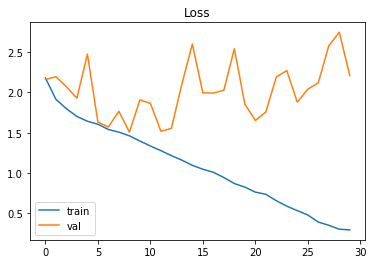

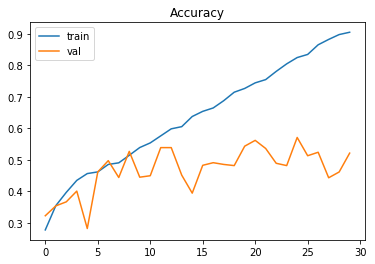

In [19]:
# resnet34, Adam, step_size=30, num_epochs=30, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs34_1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.4647 Acc: 0.1673
val Loss: 2.8139 Acc: 0.2180

Epoch 1/29
----------
train Loss: 2.1432 Acc: 0.2503
val Loss: 2.1693 Acc: 0.2760

Epoch 2/29
----------
train Loss: 2.0261 Acc: 0.2890
val Loss: 2.3457 Acc: 0.2631

Epoch 3/29
----------
train Loss: 1.9353 Acc: 0.3343
val Loss: 2.0965 Acc: 0.2889

Epoch 4/29
----------
train Loss: 1.8608 Acc: 0.3530
val Loss: 1.8232 Acc: 0.3744

Epoch 5/29
----------
train Loss: 1.7826 Acc: 0.3909
val Loss: 2.0040 Acc: 0.3588

Epoch 6/29
----------
train Loss: 1.7189 Acc: 0.4158
val Loss: 1.8070 Acc: 0.3901

Epoch 7/29
----------
train Loss: 1.6636 Acc: 0.4358
val Loss: 1.6934 Acc: 0.4333

Epoch 8/29
----------
train Loss: 1.6051 Acc: 0.4574
val Loss: 1.9364 Acc: 0.4121

Epoch 9/29
----------
train Loss: 1.5410 Acc: 0.4749
val Loss: 1.6612 Acc: 0.4499

Epoch 10/29
----------
train Loss: 1.4973 Acc: 0.4931
val Loss: 1.9903 Acc: 0.4232

Epoch 11/29
----------
train Loss: 1.4304 Acc: 0.5120
val Loss: 1.6792 Acc: 0.4664

Ep

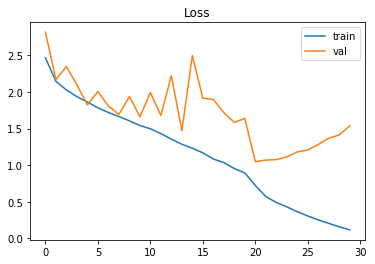

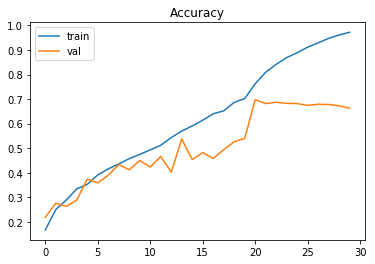

In [14]:
# resnet34, Adam, step_size=20, num_epochs=30, lr=0.01, pretrained=False
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs34_1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.3919 Acc: 0.2039
val Loss: 3.3476 Acc: 0.2410

Epoch 1/29
----------
train Loss: 2.0927 Acc: 0.2782
val Loss: 2.4162 Acc: 0.2613

Epoch 2/29
----------
train Loss: 1.9842 Acc: 0.3254
val Loss: 1.9297 Acc: 0.3330

Epoch 3/29
----------
train Loss: 1.9503 Acc: 0.3428
val Loss: 1.9817 Acc: 0.3275

Epoch 4/29
----------
train Loss: 1.8830 Acc: 0.3599
val Loss: 1.9960 Acc: 0.3303

Epoch 5/29
----------
train Loss: 1.8326 Acc: 0.3783
val Loss: 1.8706 Acc: 0.3551

Epoch 6/29
----------
train Loss: 1.7858 Acc: 0.3925
val Loss: 1.8964 Acc: 0.3818

Epoch 7/29
----------
train Loss: 1.7333 Acc: 0.4123
val Loss: 1.9082 Acc: 0.3579

Epoch 8/29
----------
train Loss: 1.6878 Acc: 0.4257
val Loss: 2.2928 Acc: 0.3054

Epoch 9/29
----------
train Loss: 1.6427 Acc: 0.4503
val Loss: 2.6784 Acc: 0.3220

Epoch 10/29
----------
train Loss: 1.5659 Acc: 0.4775
val Loss: 3.7175 Acc: 0.3496

Epoch 11/29
----------
train Loss: 1.5183 Acc: 0.4963
val Loss: 1.7820 Acc: 0.4186

Ep

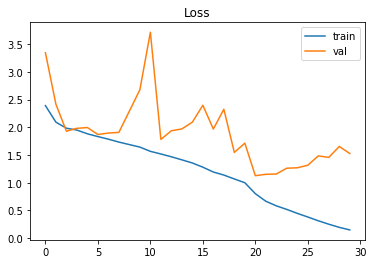

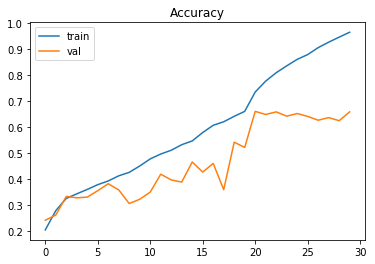

In [21]:
# resnet34, Adam, step_size=20, num_epochs=30, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs34_1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [12]:
model_ft = models.alexnet(pretrained=True)
model_ft.classifier[6].out_features = 12

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

Epoch 0/29
----------
train Loss: 2.9467 Acc: 0.1406
val Loss: 2.3511 Acc: 0.1803

Epoch 1/29
----------
train Loss: 2.1618 Acc: 0.2568
val Loss: 2.0397 Acc: 0.2907

Epoch 2/29
----------
train Loss: 2.0114 Acc: 0.2952
val Loss: 1.9614 Acc: 0.3082

Epoch 3/29
----------
train Loss: 1.9209 Acc: 0.3426
val Loss: 1.7861 Acc: 0.3744

Epoch 4/29
----------
train Loss: 1.8562 Acc: 0.3866
val Loss: 1.7468 Acc: 0.3937

Epoch 5/29
----------
train Loss: 1.7697 Acc: 0.4268
val Loss: 1.6860 Acc: 0.4591

Epoch 6/29
----------
train Loss: 1.6870 Acc: 0.4620
val Loss: 1.6337 Acc: 0.4627

Epoch 7/29
----------
train Loss: 1.6300 Acc: 0.4784
val Loss: 1.5415 Acc: 0.5106

Epoch 8/29
----------
train Loss: 1.5966 Acc: 0.4855
val Loss: 1.5650 Acc: 0.4867

Epoch 9/29
----------
train Loss: 1.5199 Acc: 0.5028
val Loss: 1.5977 Acc: 0.4821

Epoch 10/29
----------
train Loss: 1.4596 Acc: 0.5283
val Loss: 1.5687 Acc: 0.5170

Epoch 11/29
----------
train Loss: 1.4136 Acc: 0.5449
val Loss: 1.5087 Acc: 0.5143

Ep

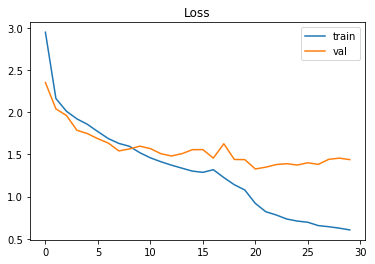

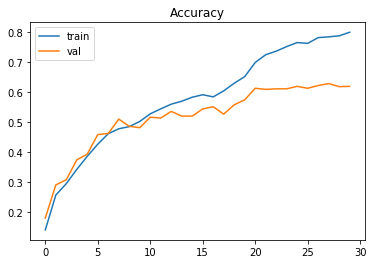

In [13]:
# AlexNet, Adam, step_size=20, num_epochs=30, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_al = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [12]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

Epoch 0/29
----------
train Loss: 2.2206 Acc: 0.2476
val Loss: 2.0136 Acc: 0.3128

Epoch 1/29
----------
train Loss: 1.9479 Acc: 0.3422
val Loss: 2.7442 Acc: 0.2732

Epoch 2/29
----------
train Loss: 1.8169 Acc: 0.3919
val Loss: 3.2856 Acc: 0.3312

Epoch 3/29
----------
train Loss: 1.6832 Acc: 0.4450
val Loss: 5.0044 Acc: 0.1362

Epoch 4/29
----------
train Loss: 1.6502 Acc: 0.4600
val Loss: 1.5980 Acc: 0.4719

Epoch 5/29
----------
train Loss: 1.5461 Acc: 0.4896
val Loss: 1.7972 Acc: 0.4388

Epoch 6/29
----------
train Loss: 1.4602 Acc: 0.5196
val Loss: 1.8580 Acc: 0.4581

Epoch 7/29
----------
train Loss: 1.4106 Acc: 0.5370
val Loss: 1.8964 Acc: 0.3864

Epoch 8/29
----------
train Loss: 1.3479 Acc: 0.5541
val Loss: 2.0310 Acc: 0.4002

Epoch 9/29
----------
train Loss: 1.3131 Acc: 0.5670
val Loss: 2.5657 Acc: 0.3165

Epoch 10/29
----------
train Loss: 1.2450 Acc: 0.5861
val Loss: 2.2587 Acc: 0.3303

Epoch 11/29
----------
train Loss: 1.1873 Acc: 0.6123
val Loss: 2.9473 Acc: 0.2374

Ep

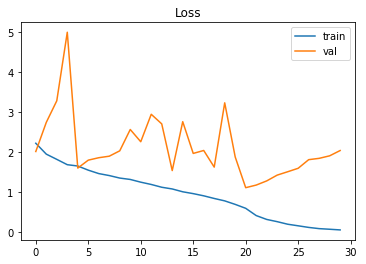

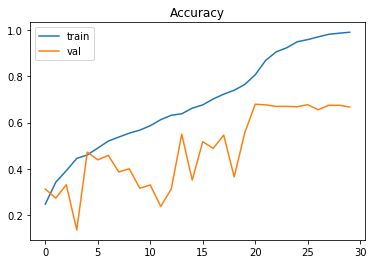

In [14]:
# resnet50, Adam, step_size=20, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs50_1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.6246 Acc: 0.1917
val Loss: 2.2234 Acc: 0.2318

Epoch 1/29
----------
train Loss: 2.1245 Acc: 0.2711
val Loss: 2.0428 Acc: 0.2677

Epoch 2/29
----------
train Loss: 2.0419 Acc: 0.2954
val Loss: 2.1127 Acc: 0.2659

Epoch 3/29
----------
train Loss: 1.9827 Acc: 0.3143
val Loss: 2.0316 Acc: 0.2659

Epoch 4/29
----------
train Loss: 1.9274 Acc: 0.3309
val Loss: 2.8061 Acc: 0.2741

Epoch 5/29
----------
train Loss: 1.8631 Acc: 0.3622
val Loss: 2.0781 Acc: 0.3220

Epoch 6/29
----------
train Loss: 1.7838 Acc: 0.3990
val Loss: 1.9891 Acc: 0.3496

Epoch 7/29
----------
train Loss: 1.7090 Acc: 0.4252
val Loss: 1.8790 Acc: 0.4103

Epoch 8/29
----------
train Loss: 1.6328 Acc: 0.4538
val Loss: 1.7968 Acc: 0.4361

Epoch 9/29
----------
train Loss: 1.5691 Acc: 0.4837
val Loss: 1.5996 Acc: 0.4765

Epoch 10/29
----------
train Loss: 1.5201 Acc: 0.4984
val Loss: 2.0739 Acc: 0.3910

Epoch 11/29
----------
train Loss: 1.4736 Acc: 0.5177
val Loss: 2.1435 Acc: 0.3431

Ep

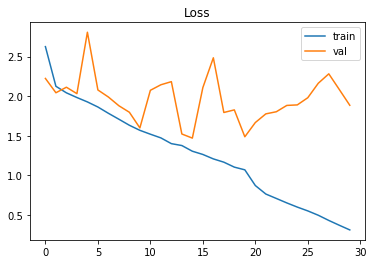

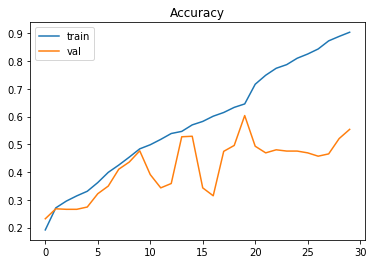

In [15]:
# resnet50, Adam, step_size=20, num_epochs=30, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs50_2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/34
----------
train Loss: 2.1603 Acc: 0.2798
val Loss: 12.7985 Acc: 0.1665

Epoch 1/34
----------
train Loss: 1.9161 Acc: 0.3702
val Loss: 1.8236 Acc: 0.4131

Epoch 2/34
----------
train Loss: 1.7644 Acc: 0.4110
val Loss: 2.7029 Acc: 0.2668

Epoch 3/34
----------
train Loss: 1.6711 Acc: 0.4475
val Loss: 2.3056 Acc: 0.3183

Epoch 4/34
----------
train Loss: 1.5753 Acc: 0.4800
val Loss: 1.7503 Acc: 0.4701

Epoch 5/34
----------
train Loss: 1.4877 Acc: 0.5092
val Loss: 1.4809 Acc: 0.5124

Epoch 6/34
----------
train Loss: 1.4172 Acc: 0.5306
val Loss: 1.8021 Acc: 0.4719

Epoch 7/34
----------
train Loss: 1.3702 Acc: 0.5506
val Loss: 1.5484 Acc: 0.5170

Epoch 8/34
----------
train Loss: 1.3066 Acc: 0.5663
val Loss: 1.5492 Acc: 0.5253

Epoch 9/34
----------
train Loss: 1.2483 Acc: 0.5948
val Loss: 1.6072 Acc: 0.5115

Epoch 10/34
----------
train Loss: 1.1876 Acc: 0.6100
val Loss: 1.7367 Acc: 0.4931

Epoch 11/34
----------
train Loss: 1.1418 Acc: 0.6245
val Loss: 1.5014 Acc: 0.5492

E

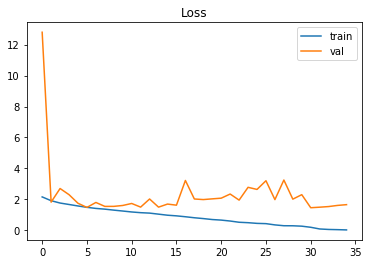

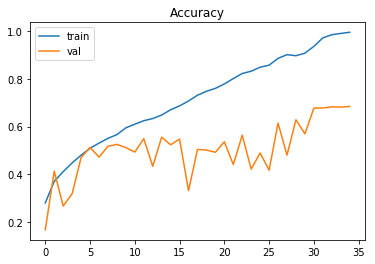

In [17]:
# resnet50, Adam, step_size=30, num_epochs=35, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs50_1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=35)

Epoch 0/49
----------
train Loss: 2.1892 Acc: 0.2720
val Loss: 2.9600 Acc: 0.2346

Epoch 1/49
----------
train Loss: 1.8990 Acc: 0.3705
val Loss: 1.7675 Acc: 0.3947

Epoch 2/49
----------
train Loss: 1.7516 Acc: 0.4310
val Loss: 1.7494 Acc: 0.4361

Epoch 3/49
----------
train Loss: 1.6657 Acc: 0.4538
val Loss: 3.0667 Acc: 0.3238

Epoch 4/49
----------
train Loss: 1.5972 Acc: 0.4738
val Loss: 1.7823 Acc: 0.4646

Epoch 5/49
----------
train Loss: 1.5268 Acc: 0.5016
val Loss: 1.8403 Acc: 0.4407

Epoch 6/49
----------
train Loss: 1.4664 Acc: 0.5168
val Loss: 2.0778 Acc: 0.3956

Epoch 7/49
----------
train Loss: 1.4143 Acc: 0.5357
val Loss: 1.5198 Acc: 0.5225

Epoch 8/49
----------
train Loss: 1.3759 Acc: 0.5525
val Loss: 1.4808 Acc: 0.5216

Epoch 9/49
----------
train Loss: 1.2993 Acc: 0.5766
val Loss: 1.5984 Acc: 0.5041

Epoch 10/49
----------
train Loss: 1.2556 Acc: 0.5874
val Loss: 1.8268 Acc: 0.4508

Epoch 11/49
----------
train Loss: 1.2016 Acc: 0.6010
val Loss: 1.6247 Acc: 0.5253

Ep

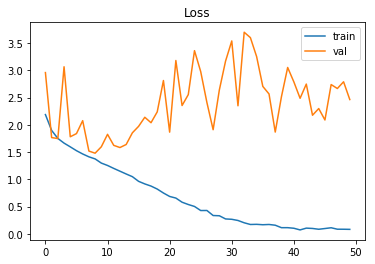

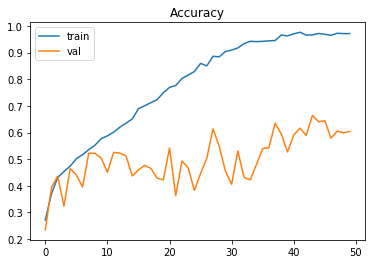

In [20]:
# resnet50, Adam, step_size=30, num_epochs=35, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs50_1 = train_model(model_ft, criterion, optimizer_ft, num_epochs=50)

In [21]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

Epoch 0/29
----------
train Loss: 2.2230 Acc: 0.2494
val Loss: 3.1792 Acc: 0.1684

Epoch 1/29
----------
train Loss: 2.0513 Acc: 0.2876
val Loss: 2.2241 Acc: 0.2594

Epoch 2/29
----------
train Loss: 1.9184 Acc: 0.3486
val Loss: 2.0083 Acc: 0.3496

Epoch 3/29
----------
train Loss: 1.8199 Acc: 0.3836
val Loss: 2.0679 Acc: 0.3864

Epoch 4/29
----------
train Loss: 1.7250 Acc: 0.4236
val Loss: 1.9816 Acc: 0.4213

Epoch 5/29
----------
train Loss: 1.6391 Acc: 0.4563
val Loss: 1.6824 Acc: 0.4545

Epoch 6/29
----------
train Loss: 1.5660 Acc: 0.4894
val Loss: 1.6687 Acc: 0.4867

Epoch 7/29
----------
train Loss: 1.4897 Acc: 0.5156
val Loss: 1.7484 Acc: 0.4655

Epoch 8/29
----------
train Loss: 1.4184 Acc: 0.5334
val Loss: 2.0298 Acc: 0.4581

Epoch 9/29
----------
train Loss: 1.3379 Acc: 0.5607
val Loss: 2.3394 Acc: 0.3983

Epoch 10/29
----------
train Loss: 1.2571 Acc: 0.5874
val Loss: 1.8573 Acc: 0.4370

Epoch 11/29
----------
train Loss: 1.1630 Acc: 0.6123
val Loss: 2.3655 Acc: 0.3385

Ep

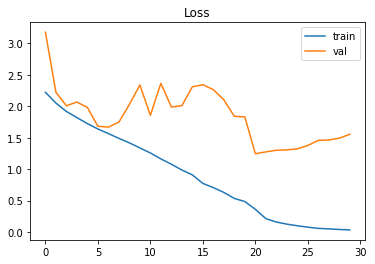

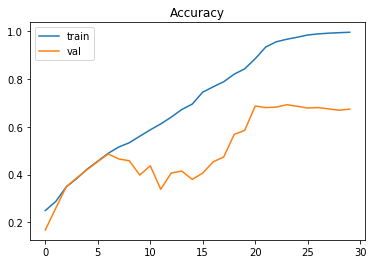

In [22]:
# resnet18, batch_size=32, Adam, step_size=20, num_epochs=35, lr=0.005, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs18_1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.2819 Acc: 0.2338
val Loss: 2.1825 Acc: 0.2870

Epoch 1/29
----------
train Loss: 2.0590 Acc: 0.3152
val Loss: 2.9433 Acc: 0.2245

Epoch 2/29
----------
train Loss: 1.9152 Acc: 0.3682
val Loss: 3.1916 Acc: 0.2833

Epoch 3/29
----------
train Loss: 1.8220 Acc: 0.3948
val Loss: 1.9703 Acc: 0.3606

Epoch 4/29
----------
train Loss: 1.7356 Acc: 0.4190
val Loss: 4.9936 Acc: 0.2843

Epoch 5/29
----------
train Loss: 1.6304 Acc: 0.4597
val Loss: 2.4971 Acc: 0.3017

Epoch 6/29
----------
train Loss: 1.5682 Acc: 0.4869
val Loss: 1.9572 Acc: 0.3652

Epoch 7/29
----------
train Loss: 1.5076 Acc: 0.5014
val Loss: 2.0922 Acc: 0.3937

Epoch 8/29
----------
train Loss: 1.4334 Acc: 0.5219
val Loss: 2.6385 Acc: 0.3726

Epoch 9/29
----------
train Loss: 1.3636 Acc: 0.5456
val Loss: 2.9484 Acc: 0.4011

Epoch 10/29
----------
train Loss: 1.3021 Acc: 0.5693
val Loss: 1.6923 Acc: 0.4839

Epoch 11/29
----------
train Loss: 1.2220 Acc: 0.5983
val Loss: 2.9274 Acc: 0.3698

Ep

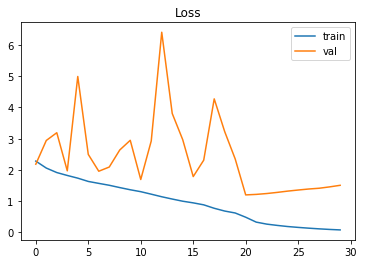

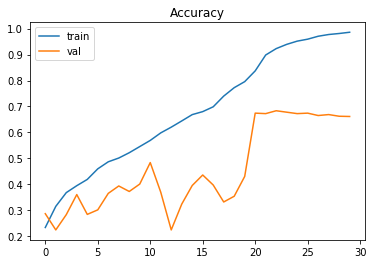

In [25]:
# resnet18, batch_size=64, Adam, step_size=20, num_epochs=30, lr=0.005, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs18 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.0084 Acc: 0.3203
val Loss: 2.0156 Acc: 0.3680

Epoch 1/29
----------
train Loss: 1.7872 Acc: 0.4036
val Loss: 2.3888 Acc: 0.3330

Epoch 2/29
----------
train Loss: 1.6692 Acc: 0.4459
val Loss: 2.2315 Acc: 0.3689

Epoch 3/29
----------
train Loss: 1.5934 Acc: 0.4687
val Loss: 2.1379 Acc: 0.4213

Epoch 4/29
----------
train Loss: 1.5108 Acc: 0.4919
val Loss: 2.3583 Acc: 0.4480

Epoch 5/29
----------
train Loss: 1.4531 Acc: 0.5182
val Loss: 2.8970 Acc: 0.3882

Epoch 6/29
----------
train Loss: 1.3803 Acc: 0.5419
val Loss: 1.5913 Acc: 0.4894

Epoch 7/29
----------
train Loss: 1.3034 Acc: 0.5674
val Loss: 1.5741 Acc: 0.5069

Epoch 8/29
----------
train Loss: 1.2625 Acc: 0.5838
val Loss: 2.3589 Acc: 0.3063

Epoch 9/29
----------
train Loss: 1.1773 Acc: 0.6098
val Loss: 1.9012 Acc: 0.3983

Epoch 10/29
----------
train Loss: 1.1179 Acc: 0.6318
val Loss: 1.8911 Acc: 0.4269

Epoch 11/29
----------
train Loss: 1.0509 Acc: 0.6514
val Loss: 1.8573 Acc: 0.4545

Ep

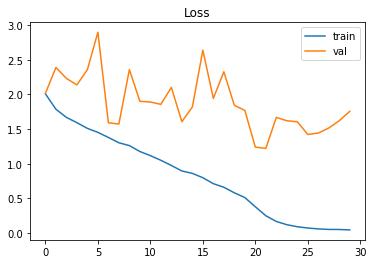

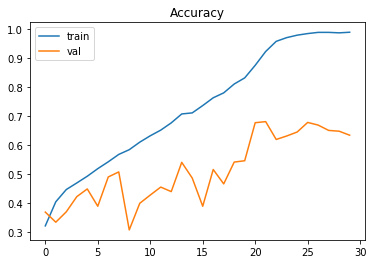

In [26]:
# resnet18, batch_size=64, Adam, step_size=20, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.5)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs18 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.0803 Acc: 0.2865
val Loss: 2.1128 Acc: 0.3487

Epoch 1/29
----------
train Loss: 1.8331 Acc: 0.3914
val Loss: 2.1670 Acc: 0.3450

Epoch 2/29
----------
train Loss: 1.7161 Acc: 0.4310
val Loss: 2.0722 Acc: 0.3937

Epoch 3/29
----------
train Loss: 1.6225 Acc: 0.4577
val Loss: 1.9989 Acc: 0.4085

Epoch 4/29
----------
train Loss: 1.5454 Acc: 0.4832
val Loss: 2.1164 Acc: 0.3707

Epoch 5/29
----------
train Loss: 1.4931 Acc: 0.5048
val Loss: 2.0532 Acc: 0.4131

Epoch 6/29
----------
train Loss: 1.4271 Acc: 0.5343
val Loss: 1.5848 Acc: 0.4885

Epoch 7/29
----------
train Loss: 1.3589 Acc: 0.5536
val Loss: 1.4667 Acc: 0.5483

Epoch 8/29
----------
train Loss: 1.2936 Acc: 0.5750
val Loss: 1.8227 Acc: 0.4913

Epoch 9/29
----------
train Loss: 1.2341 Acc: 0.5946
val Loss: 1.5822 Acc: 0.5327

Epoch 10/29
----------
train Loss: 1.0785 Acc: 0.6500
val Loss: 1.2385 Acc: 0.6173

Epoch 11/29
----------
train Loss: 0.9915 Acc: 0.6774
val Loss: 1.2216 Acc: 0.6219

Ep

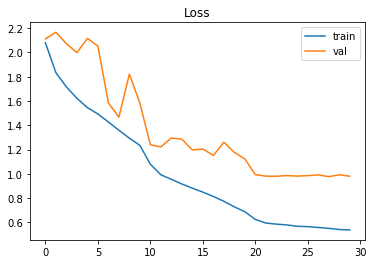

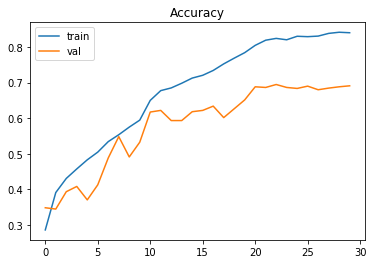

In [27]:
# resnet18, batch_size=64, Adam, step_size=10, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs18 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/39
----------
train Loss: 2.0329 Acc: 0.3145
val Loss: 2.2229 Acc: 0.2971

Epoch 1/39
----------
train Loss: 1.8124 Acc: 0.3909
val Loss: 2.6049 Acc: 0.2925

Epoch 2/39
----------
train Loss: 1.6864 Acc: 0.4399
val Loss: 2.2464 Acc: 0.3855

Epoch 3/39
----------
train Loss: 1.5948 Acc: 0.4643
val Loss: 2.1411 Acc: 0.3671

Epoch 4/39
----------
train Loss: 1.5208 Acc: 0.4959
val Loss: 2.5365 Acc: 0.3468

Epoch 5/39
----------
train Loss: 1.4512 Acc: 0.5173
val Loss: 1.9452 Acc: 0.4315

Epoch 6/39
----------
train Loss: 1.3849 Acc: 0.5421
val Loss: 2.3630 Acc: 0.4039

Epoch 7/39
----------
train Loss: 1.3287 Acc: 0.5573
val Loss: 1.4356 Acc: 0.5373

Epoch 8/39
----------
train Loss: 1.2760 Acc: 0.5858
val Loss: 2.2358 Acc: 0.4250

Epoch 9/39
----------
train Loss: 1.1946 Acc: 0.6049
val Loss: 3.0159 Acc: 0.3910

Epoch 10/39
----------
train Loss: 1.0299 Acc: 0.6562
val Loss: 1.0669 Acc: 0.6605

Epoch 11/39
----------
train Loss: 0.9314 Acc: 0.6931
val Loss: 1.0473 Acc: 0.6624

Ep

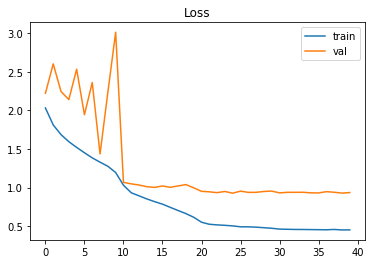

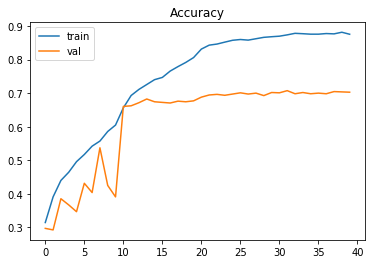

In [28]:
# resnet18, batch_size=64, Adam, step_size=10, num_epochs=40, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs18 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)

Epoch 0/11
----------
train Loss: 1.9279 Acc: 0.3530
val Loss: 1.6975 Acc: 0.4710

Epoch 1/11
----------
train Loss: 1.5707 Acc: 0.4844
val Loss: 1.5169 Acc: 0.5244

Epoch 2/11
----------
train Loss: 1.3951 Acc: 0.5451
val Loss: 1.4544 Acc: 0.5317

Epoch 3/11
----------
train Loss: 1.2397 Acc: 0.5994
val Loss: 1.5093 Acc: 0.5143

Epoch 4/11
----------
train Loss: 1.0926 Acc: 0.6599
val Loss: 1.3342 Acc: 0.5566

Epoch 5/11
----------
train Loss: 0.9388 Acc: 0.7071
val Loss: 1.5165 Acc: 0.5511

Epoch 6/11
----------
train Loss: 0.8010 Acc: 0.7543
val Loss: 1.5640 Acc: 0.5354

Epoch 7/11
----------
train Loss: 0.6908 Acc: 0.7927
val Loss: 1.6466 Acc: 0.5391

Epoch 8/11
----------
train Loss: 0.5982 Acc: 0.8212
val Loss: 2.7093 Acc: 0.3671

Epoch 9/11
----------
train Loss: 0.5044 Acc: 0.8497
val Loss: 1.6384 Acc: 0.5087

Epoch 10/11
----------
train Loss: 0.3291 Acc: 0.9103
val Loss: 1.0673 Acc: 0.6743

Epoch 11/11
----------
train Loss: 0.2223 Acc: 0.9531
val Loss: 1.0769 Acc: 0.6651

Tr

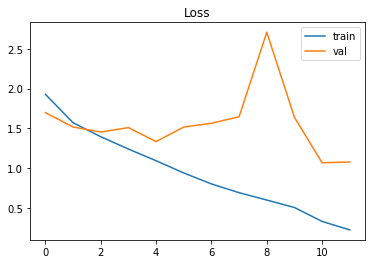

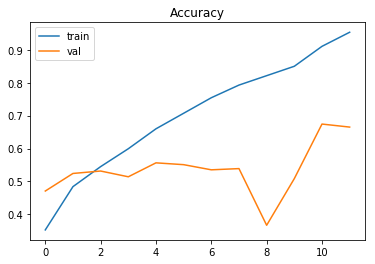

In [29]:
# resnet18, batch_size=64, Adam, step_size=10, num_epochs=10, lr=0.0001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs18 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=12)

Epoch 0/19
----------
train Loss: 1.9267 Acc: 0.3534
val Loss: 1.8380 Acc: 0.4167

Epoch 1/19
----------
train Loss: 1.5861 Acc: 0.4747
val Loss: 1.5553 Acc: 0.5097

Epoch 2/19
----------
train Loss: 1.4107 Acc: 0.5391
val Loss: 1.3602 Acc: 0.5713

Epoch 3/19
----------
train Loss: 1.2423 Acc: 0.5955
val Loss: 1.3444 Acc: 0.5704

Epoch 4/19
----------
train Loss: 1.0827 Acc: 0.6611
val Loss: 1.3647 Acc: 0.5437

Epoch 5/19
----------
train Loss: 0.9199 Acc: 0.7214
val Loss: 1.5259 Acc: 0.4857

Epoch 6/19
----------
train Loss: 0.8082 Acc: 0.7547
val Loss: 2.0304 Acc: 0.4775

Epoch 7/19
----------
train Loss: 0.6953 Acc: 0.7872
val Loss: 1.8995 Acc: 0.4545

Epoch 8/19
----------
train Loss: 0.6135 Acc: 0.8180
val Loss: 1.9462 Acc: 0.4793

Epoch 9/19
----------
train Loss: 0.4928 Acc: 0.8590
val Loss: 1.6554 Acc: 0.5373

Epoch 10/19
----------
train Loss: 0.3745 Acc: 0.9008
val Loss: 1.6661 Acc: 0.5511

Epoch 11/19
----------
train Loss: 0.2914 Acc: 0.9254
val Loss: 1.6113 Acc: 0.5501

Ep

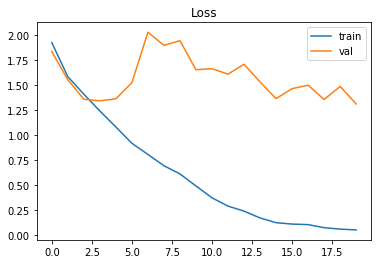

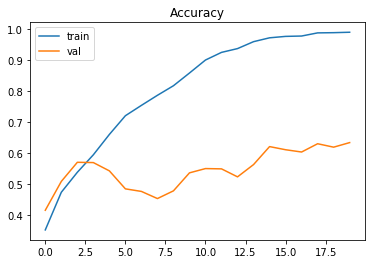

In [30]:
# resnet18, batch_size=64, Adam, step_size=20, num_epochs=20, lr=0.0001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs18 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

In [12]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

Epoch 0/29
----------
train Loss: 2.2680 Acc: 0.2363
val Loss: 2.1384 Acc: 0.2254

Epoch 1/29
----------
train Loss: 2.0179 Acc: 0.3327
val Loss: 2.5990 Acc: 0.2364

Epoch 2/29
----------
train Loss: 1.8738 Acc: 0.3827
val Loss: 1.9505 Acc: 0.4057

Epoch 3/29
----------
train Loss: 1.7962 Acc: 0.4190
val Loss: 1.8259 Acc: 0.4057

Epoch 4/29
----------
train Loss: 1.7150 Acc: 0.4399
val Loss: 2.3666 Acc: 0.3937

Epoch 5/29
----------
train Loss: 1.6682 Acc: 0.4549
val Loss: 1.6008 Acc: 0.4821

Epoch 6/29
----------
train Loss: 1.6052 Acc: 0.4867
val Loss: 1.5786 Acc: 0.4729

Epoch 7/29
----------
train Loss: 1.5475 Acc: 0.5055
val Loss: 1.5913 Acc: 0.4940

Epoch 8/29
----------
train Loss: 1.5107 Acc: 0.5018
val Loss: 1.7235 Acc: 0.4867

Epoch 9/29
----------
train Loss: 1.4625 Acc: 0.5288
val Loss: 1.4034 Acc: 0.5437

Epoch 10/29
----------
train Loss: 1.4339 Acc: 0.5334
val Loss: 1.4709 Acc: 0.5161

Epoch 11/29
----------
train Loss: 1.3770 Acc: 0.5550
val Loss: 1.6746 Acc: 0.5124

Ep

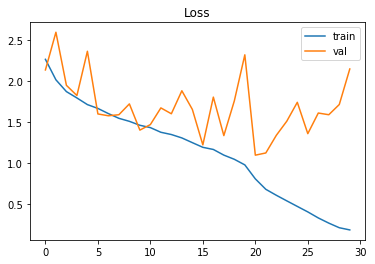

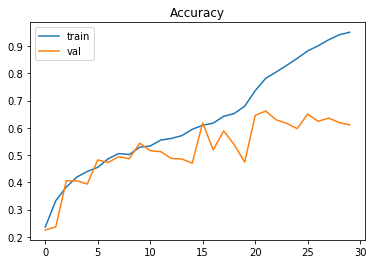

In [13]:
# resnet101, batch_size=16, Adam, step_size=20, num_epochs=30, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_rs101 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.4620 Acc: 0.1659
val Loss: 2.3140 Acc: 0.1812

Epoch 1/29
----------
train Loss: 2.3122 Acc: 0.1822
val Loss: 2.2907 Acc: 0.1895

Epoch 2/29
----------
train Loss: 2.2911 Acc: 0.1924
val Loss: 2.3839 Acc: 0.1895

Epoch 3/29
----------
train Loss: 2.1496 Acc: 0.2600
val Loss: 2.2912 Acc: 0.2557

Epoch 4/29
----------
train Loss: 2.0517 Acc: 0.3037
val Loss: 2.1365 Acc: 0.3128

Epoch 5/29
----------
train Loss: 1.9900 Acc: 0.3263
val Loss: 1.9452 Acc: 0.3358

Epoch 6/29
----------
train Loss: 1.9173 Acc: 0.3507
val Loss: 1.8826 Acc: 0.3560

Epoch 7/29
----------
train Loss: 1.8608 Acc: 0.3829
val Loss: 1.9104 Acc: 0.3459

Epoch 8/29
----------
train Loss: 1.8076 Acc: 0.4040
val Loss: 1.8014 Acc: 0.4333

Epoch 9/29
----------
train Loss: 1.7459 Acc: 0.4291
val Loss: 1.6790 Acc: 0.4554

Epoch 10/29
----------
train Loss: 1.6145 Acc: 0.4671
val Loss: 1.4914 Acc: 0.5133

Epoch 11/29
----------
train Loss: 1.5522 Acc: 0.4839
val Loss: 1.4614 Acc: 0.5124

Ep

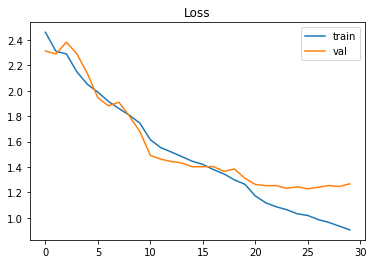

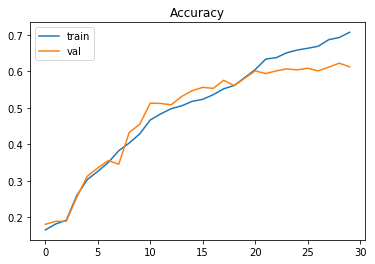

In [14]:
# resnet101, batch_size=16, Adam, step_size=10, num_epochs=30, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs101 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/11
----------
train Loss: 3.0443 Acc: 0.1526
val Loss: 2.6429 Acc: 0.1490

Epoch 1/11
----------
train Loss: 2.3531 Acc: 0.1749
val Loss: 2.7910 Acc: 0.1656

Epoch 2/11
----------
train Loss: 2.3983 Acc: 0.1574
val Loss: 2.3446 Acc: 0.1500

Epoch 3/11
----------
train Loss: 2.3428 Acc: 0.1730
val Loss: 2.6762 Acc: 0.1435

Epoch 4/11
----------
train Loss: 2.2801 Acc: 0.1979
val Loss: 2.1897 Acc: 0.2190

Epoch 5/11
----------
train Loss: 2.1870 Acc: 0.2414
val Loss: 2.1704 Acc: 0.2677

Epoch 6/11
----------
train Loss: 2.1273 Acc: 0.2683
val Loss: 2.2278 Acc: 0.2374

Epoch 7/11
----------
train Loss: 2.0904 Acc: 0.2816
val Loss: 2.4179 Acc: 0.2033

Epoch 8/11
----------
train Loss: 2.1254 Acc: 0.2738
val Loss: 2.1272 Acc: 0.2493

Epoch 9/11
----------
train Loss: 2.0774 Acc: 0.2862
val Loss: 2.0777 Acc: 0.3100

Epoch 10/11
----------
train Loss: 1.9962 Acc: 0.3150
val Loss: 1.9562 Acc: 0.3211

Epoch 11/11
----------
train Loss: 1.9745 Acc: 0.3164
val Loss: 1.9497 Acc: 0.3201

Tr

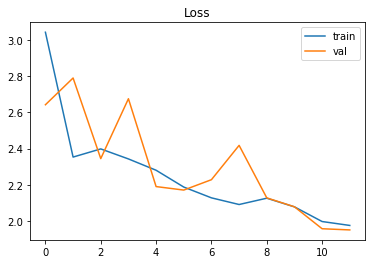

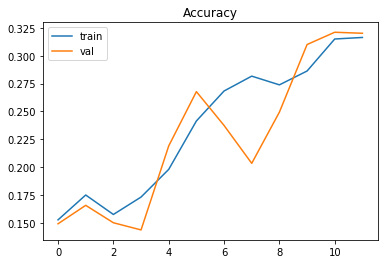

In [15]:
# resnet101, batch_size=16, Adam, step_size=10, num_epochs=12, lr=0.1, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_rs101 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=12)

Epoch 0/29
----------
train Loss: 2.5296 Acc: 0.1473
val Loss: 2.3815 Acc: 0.1380

Epoch 1/29
----------
train Loss: 2.3250 Acc: 0.1657
val Loss: 2.6956 Acc: 0.1886

Epoch 2/29
----------
train Loss: 2.1867 Acc: 0.2522
val Loss: 2.5186 Acc: 0.1343

Epoch 3/29
----------
train Loss: 2.1674 Acc: 0.2552
val Loss: 2.4852 Acc: 0.2438

Epoch 4/29
----------
train Loss: 2.0922 Acc: 0.2869
val Loss: 2.3834 Acc: 0.2502

Epoch 5/29
----------
train Loss: 2.0393 Acc: 0.2987
val Loss: 2.0676 Acc: 0.2925

Epoch 6/29
----------
train Loss: 2.0019 Acc: 0.3185
val Loss: 2.0138 Acc: 0.3358

Epoch 7/29
----------
train Loss: 1.9398 Acc: 0.3445
val Loss: 1.9595 Acc: 0.3183

Epoch 8/29
----------
train Loss: 1.8865 Acc: 0.3640
val Loss: 1.9158 Acc: 0.3229

Epoch 9/29
----------
train Loss: 1.8286 Acc: 0.3843
val Loss: 1.8342 Acc: 0.3855

Epoch 10/29
----------
train Loss: 1.7700 Acc: 0.4167
val Loss: 1.8945 Acc: 0.3993

Epoch 11/29
----------
train Loss: 1.7391 Acc: 0.4273
val Loss: 1.7113 Acc: 0.4775

Ep

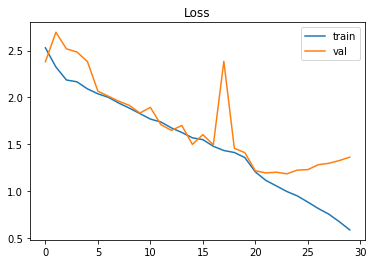

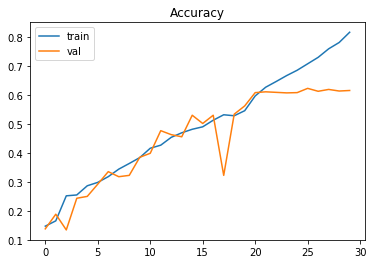

In [13]:
# resnet101, batch_size=16, Adam, step_size=10, num_epochs=20, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
model_ft.apply(reset)
model_rs101 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [14]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

Epoch 0/39
----------
train Loss: 2.5002 Acc: 0.1461
val Loss: 2.3542 Acc: 0.1389

Epoch 1/39
----------
train Loss: 2.3038 Acc: 0.1767
val Loss: 2.3096 Acc: 0.2052

Epoch 2/39
----------
train Loss: 2.1667 Acc: 0.2520
val Loss: 2.1422 Acc: 0.2521

Epoch 3/39
----------
train Loss: 2.0981 Acc: 0.2701
val Loss: 2.1096 Acc: 0.2622

Epoch 4/39
----------
train Loss: 2.0519 Acc: 0.3023
val Loss: 2.0864 Acc: 0.2613

Epoch 5/39
----------
train Loss: 1.9969 Acc: 0.3171
val Loss: 1.9679 Acc: 0.3533

Epoch 6/39
----------
train Loss: 1.9491 Acc: 0.3359
val Loss: 1.8636 Acc: 0.3689

Epoch 7/39
----------
train Loss: 1.9011 Acc: 0.3594
val Loss: 1.8882 Acc: 0.3717

Epoch 8/39
----------
train Loss: 1.8820 Acc: 0.3555
val Loss: 1.8781 Acc: 0.3477

Epoch 9/39
----------
train Loss: 1.8557 Acc: 0.3797
val Loss: 1.7529 Acc: 0.4020

Epoch 10/39
----------
train Loss: 1.8171 Acc: 0.3925
val Loss: 1.7396 Acc: 0.4241

Epoch 11/39
----------
train Loss: 1.7784 Acc: 0.4084
val Loss: 1.6914 Acc: 0.4627

Ep

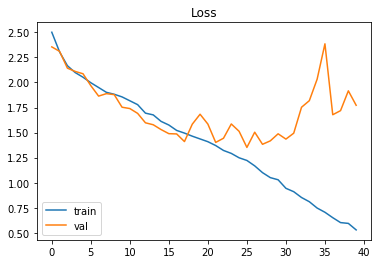

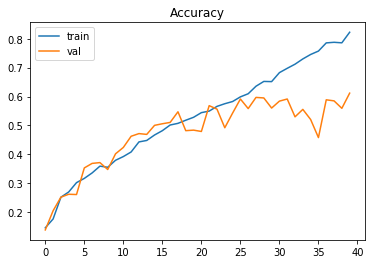

In [13]:
# resnet101, batch_size=16, Adam, no lr_scheduler, num_epochs=60, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
model_ft.apply(reset)
model_rs101 = train_model(model_ft, criterion, optimizer_ft, num_epochs=40)

Epoch 0/4
----------
train Loss: 2.4375 Acc: 0.2195
val Loss: 6.4939 Acc: 0.2061
lr  0.01

Epoch 1/4
----------
train Loss: 2.1268 Acc: 0.2637
val Loss: 2.2579 Acc: 0.2677
lr  0.01

Epoch 2/4
----------
train Loss: 2.0394 Acc: 0.2904
val Loss: 1.9834 Acc: 0.3063
lr  0.001

Epoch 3/4
----------
train Loss: 1.9976 Acc: 0.3072
val Loss: 1.9830 Acc: 0.3413
lr  0.001

Epoch 4/4
----------
train Loss: 1.9660 Acc: 0.3219
val Loss: 1.9542 Acc: 0.3431
lr  0.001

Training complete in 7m 39s
Best val Acc: 0.343146, epoch 4


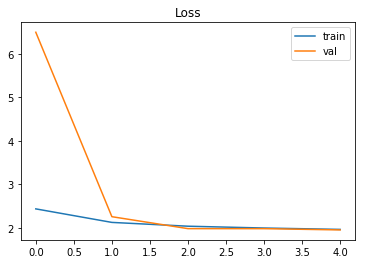

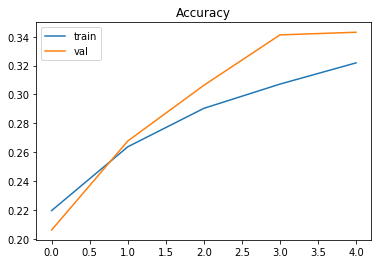

In [13]:
# checking MultiStepLR
# resnet101, batch_size=16, Adam, step_size=10, num_epochs=20, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=17, gamma=0.1)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[2], gamma=0.1)
model_ft.apply(reset)
model_rs101 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/39
----------
train Loss: 2.4942 Acc: 0.1574
val Loss: 2.8626 Acc: 0.1196
lr:  0.01

Epoch 1/39
----------
train Loss: 2.2508 Acc: 0.2092
val Loss: 4.7484 Acc: 0.1592
lr:  0.01

Epoch 2/39
----------
train Loss: 2.1679 Acc: 0.2533
val Loss: 2.3741 Acc: 0.1886
lr:  0.01

Epoch 3/39
----------
train Loss: 2.1143 Acc: 0.2642
val Loss: 2.0212 Acc: 0.2879
lr:  0.01

Epoch 4/39
----------
train Loss: 2.0439 Acc: 0.3014
val Loss: 1.9906 Acc: 0.3109
lr:  0.01

Epoch 5/39
----------
train Loss: 2.0175 Acc: 0.3060
val Loss: 1.8961 Acc: 0.3459
lr:  0.01

Epoch 6/39
----------
train Loss: 1.9889 Acc: 0.3217
val Loss: 2.0639 Acc: 0.2806
lr:  0.01

Epoch 7/39
----------
train Loss: 1.9706 Acc: 0.3244
val Loss: 1.8678 Acc: 0.3781
lr:  0.01

Epoch 8/39
----------
train Loss: 1.9445 Acc: 0.3382
val Loss: 1.8639 Acc: 0.3661
lr:  0.01

Epoch 9/39
----------
train Loss: 1.9085 Acc: 0.3470
val Loss: 1.9042 Acc: 0.3367
lr:  0.01

Epoch 10/39
----------
train Loss: 1.8961 Acc: 0.3491
val Loss: 1.8309

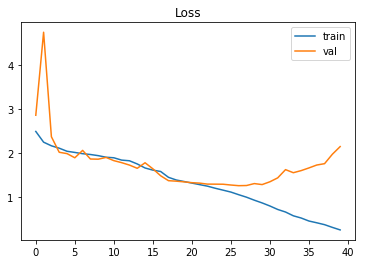

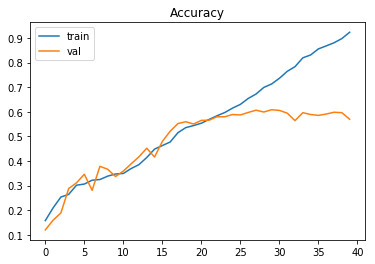

In [13]:
# resnet101, batch_size=16, Adam, milestones=17, num_epochs=40, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=17, gamma=0.1)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[17], gamma=0.1)
model_ft.apply(reset)
model_rs101 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)

Epoch 0/9
----------
train Loss: 0.7573 Acc: 0.7575
val Loss: 1.2261 Acc: 0.6182
lr:  0.0001

Epoch 1/9
----------
train Loss: 0.7002 Acc: 0.7759
val Loss: 1.2289 Acc: 0.6210
lr:  0.0001

Epoch 2/9
----------
train Loss: 0.6675 Acc: 0.7938
val Loss: 1.2320 Acc: 0.6164
lr:  0.0001

Epoch 3/9
----------
train Loss: 0.6491 Acc: 0.7996
val Loss: 1.2392 Acc: 0.6145
lr:  0.0001

Epoch 4/9
----------
train Loss: 0.6334 Acc: 0.8035
val Loss: 1.2505 Acc: 0.6136
lr:  0.0001

Epoch 5/9
----------
train Loss: 0.6056 Acc: 0.8171
val Loss: 1.2657 Acc: 0.6145
lr:  0.0001

Epoch 6/9
----------
train Loss: 0.5881 Acc: 0.8226
val Loss: 1.2691 Acc: 0.6127
lr:  0.0001

Epoch 7/9
----------
train Loss: 0.5656 Acc: 0.8267
val Loss: 1.2761 Acc: 0.6136
lr:  0.0001

Epoch 8/9
----------
train Loss: 0.5356 Acc: 0.8412
val Loss: 1.2982 Acc: 0.6173
lr:  0.0001

Epoch 9/9
----------
train Loss: 0.5331 Acc: 0.8408
val Loss: 1.3158 Acc: 0.6127
lr:  0.0001

Training complete in 15m 19s
Best val Acc: 0.620975, epoch 1

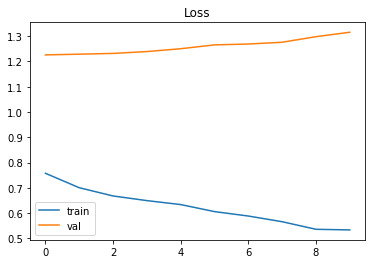

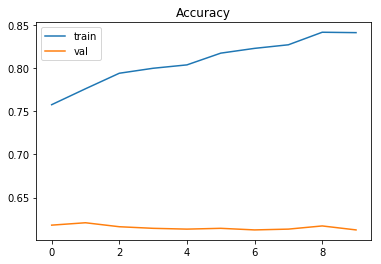

In [14]:
# resnet101, batch_size=16, Adam, milestones=17, num_epochs=40, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
model_rs101 = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

Epoch 0/16
----------
train Loss: 2.5536 Acc: 0.1521
val Loss: 2.3603 Acc: 0.1923
lr:  0.01

Epoch 1/16
----------
train Loss: 2.1672 Acc: 0.2384
val Loss: 24.9949 Acc: 0.1877
lr:  0.01

Epoch 2/16
----------
train Loss: 2.1076 Acc: 0.2766
val Loss: 2.1440 Acc: 0.2925
lr:  0.01

Epoch 3/16
----------
train Loss: 2.0315 Acc: 0.3132
val Loss: 2.0476 Acc: 0.3082
lr:  0.01

Epoch 4/16
----------
train Loss: 2.0115 Acc: 0.3251
val Loss: 1.9570 Acc: 0.3339
lr:  0.01

Epoch 5/16
----------
train Loss: 1.9437 Acc: 0.3412
val Loss: 1.9257 Acc: 0.3367
lr:  0.01

Epoch 6/16
----------
train Loss: 1.9253 Acc: 0.3493
val Loss: 1.9486 Acc: 0.3358
lr:  0.01

Epoch 7/16
----------
train Loss: 1.8852 Acc: 0.3682
val Loss: 1.9737 Acc: 0.3707
lr:  0.01

Epoch 8/16
----------
train Loss: 1.8463 Acc: 0.3780
val Loss: 1.8965 Acc: 0.3717
lr:  0.01

Epoch 9/16
----------
train Loss: 1.7940 Acc: 0.3923
val Loss: 1.7480 Acc: 0.4315
lr:  0.01

Epoch 10/16
----------
train Loss: 1.7273 Acc: 0.4261
val Loss: 1.673

TypeError: 'ResNet' object is not iterable

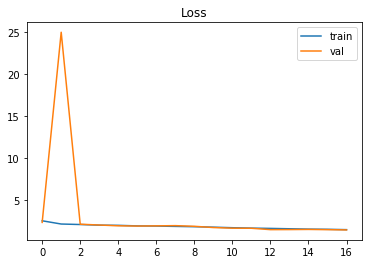

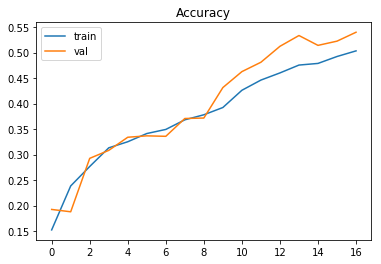

In [16]:
# resnet101, batch_size=16, Adam, no lr_scheduler, num_epochs=60, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
model_ft.apply(reset)
model_rs101_1, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, num_epochs=17)

In [33]:
# resnet101, batch_size=16, Adam, no lr_scheduler, num_epochs=60, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
model_ft.apply(reset)
model_rs101_1, loss_log, acc_log = train_model(model_ft, criterion, optimizer_ft, num_epochs=17)

Epoch 0/16
----------
train Loss: 2.4837 Acc: 0.1500


RuntimeError: cuda runtime error (2) : out of memory at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCStorage.cu:58

In [32]:
torch.save(model_rs101_1, 'model_rs101_1')
with open('loss_log_model_rs101_1.pkl', 'wb') as file:
    pickle.dump(loss_log, file, pickle.HIGHEST_PROTOCOL)
with open('acc_log_model_rs101_1.pkl', 'wb') as file:
    pickle.dump(acc_log, file, pickle.HIGHEST_PROTOCOL)    

In [ ]:
model_rs101_1 = torch.load('model_rs101_1')
with open('loss_log_model_rs101_1.pkl', 'rb') as file:
    loss_log_rs101_1 = pickle.load(file)
with open('acc_log_model_rs101_1.pkl', 'rb') as file:
    acc_log_rs101_1 = pickle.load(file)

In [19]:
# resnet101, batch_size=16, Adam, no lr_scheduler, num_epochs=60, lr=0.01, pretrained=True
optimizer_ft = optim.Adam(model_rs101_1.parameters(), lr=0.01)
model_rs101_2, _, _ = train_model(model_rs101_1, criterion, optimizer_ft, num_epochs=3)

NameError: name 'model_rs101_1' is not defined